In [2]:
import statsmodels as sm
import statistics 
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np
import math
import itertools
import datetime as dt
import pypfopt
import textwrap

Introduction

In this exercises you take the role of a financial advisors. You advice your client, a normal US American employee saving for retirement in his tax-
free 401K pension account, on the structuring of his or her retirement portfolio. To structure the client’s portfolio ETFs for stocks, bonds,
alternative assets and US equity factors are useful tools due to their liquidity, low transactions costs and transparency. The modern portfolio
management methodologies can be used as well to create and elaborate alternative portfolio allocations compared to the classic 60%/40% portfolio of
stocks and bonds. To think about factor investing you ought to take a look at the latest published research of the quant asset management boutique AQR
Capital Management, in which the authors ask whether value-investing, the focus on undervalued stocks, is no longer profitable compared to investing
into growth stocks that dominate the capital markets since the last 10+ years (Ronen, Laursen, & Richardson, 2020; Asness, 2020). Further investment
perspectives, or views, are incorporated in the portfolio construction process using the Black-Litterman Model, in particular to model the higher
expected returns on European and emerging market equity and lower yields on long-term US Treasury bonds (Black & Litterman, 1991; 1992). A practical
summary of the Black-Litterman model is provided by (Idzorek, 2007). Finally the mitigation or portfolio risks by focusing on low-volatility stocks
might be interesting, also to reduce the tail-risks measured by the Value-at-Risk (Frazzini, Friedman, & Hoon, 2012). Thus to create and test portfolios the data used in the exercises are the time series of liquid ETFs shown in the worksheet “ETF & FF Factor Time Series“ in the excel file
“Assignments2020_QP&PRM_21-09-2020”. Similar to assignment 1 ideally use Python with AnaConda and Jupyter notebooks as well as the Python-Portfolio
Optimizer, which also includes the Black-Litterman model with the incorporation of confidence levels according to (Idzorek, 2007). To calculate the
Value-at-Risk with Python many resources can be found online, in particular for the simpler delta-normal approach and historical simulation.

Exercise 1 (7 points)

First the baseline 60/40 portfolio of 60% equity and 40% bonds is created from the eight ETFs that are the most liquid ones traded at the NYSE and
represent the broadest segment of the respective global equity and US bond markets. The ETF price time series start on July 18th 2013 until September
16th 2020. For an approximation of the risk-free rate in the USA use the 13 week, or three month, US Treasury Bill (IRX) expressed in percent per
annum, published daily by the US Federal Reserve. The exchange rates of EUR and YEN to the USD are also provided, as well as the broadest index of the
US equity markets to approximate the universe of stocks relevant for the client for his retirement portfolio planning.

(a)     4 points: From a US investors perspective the classic 60%/40% portfolio includes in the equity part of 60% an allocation of 70% US equity,
approximated by the Russell 2000, which includes small- and mid-cap stocks compared to the S&P 500, followed by 10% of equity each allocated to
Europe, approximated by the STOXX Europe 600, 10% emerging market equity and 10% Japanese equity. The 40% in US bonds, to avoid in the “safe” part of
the portfolio any foreign exchange or country risks, is allocated evenly with 10% each to long-term US Treasury bonds with a maturity of 20+ years, US
aggregate bonds that also include municipalities, mortgage-backed securities, etc., as well as high-yield and investment grade corporate bonds. The
benchmark portfolio is from a US investor’s perspective simply a portfolio of 60% in the Wilshire 5000 Total Market Index (W5000) and 40% in three-
month US Treasury Bills. Calculate for this simple baseline portfolio the annualized returns, Sharpe ratio, and volatility as well as the rolling
maximum drawdown from July 18th 2013 until September 16th 2019, and also for each quarter ending March, June, September and December. Also assume
monthly portfolio rebalancing for both, the baseline portfolio and the benchmark portfolio. Do the same for the benchmark portfolio. What do you
observe? How do the portfolio weights evolve when applying the Markowitz portfolio theory? How did the portfolio perform during the recent Corona
crisis from February 20th 2020 until March 23rd 2020, compared to the benchmark?

In [4]:
# get the df
time_series_all = pd.read_excel(r'/Users/filippomariamazzocca/Desktop/Assignments portfolio risk management/Assignment 2/input_assignment2.xlsm', sheet_name = 'ETF & FF Factor Time Series', index_col = 0)
#time_series_all = time_series_all_2.iloc[2656:, :]

In [5]:
# get the dataframe of different portfolios with returns, portfolio values, and weightings
def get_df(ptf_col, initial_weight, columns, n, s):
    ptf = time_series_all.iloc[s:, ptf_col]
    
    if n == 12:
        ptf.iloc[:, 5] = time_series_all.iloc[s:, 10] / time_series_all.iloc[s:,0]
        ptf.iloc[:, 7] = time_series_all.iloc[s:, 12] / time_series_all.iloc[s:,1]
        ptf = ptf.pct_change(fill_method ='bfill')
        #ptf.fillna(method='bfill')
        
    elif n == 8:
        ptf.iloc[:, 1] = time_series_all.iloc[s:, 10] / time_series_all.iloc[s:,0]
        ptf.iloc[:, 3] = time_series_all.iloc[s:, 12] / time_series_all.iloc[s:,1]
        ptf = ptf.pct_change()        
            
    elif n == 2:
        ptf = ptf.pct_change()
        ptf.iloc[:, 1] = time_series_all.iloc[s:, 6] / (100*360)     #Because presented in percent per annum, 360 is the day convention

    else:
        ptf = ptf.pct_change()
    
    initial_weight_df = pd.DataFrame(data = [initial_weight], columns = columns)
    new_columns = columns + ['return_m']
    weight_ret = pd.DataFrame(columns = new_columns)
    idx = 0
    
    for i, row in initial_weight_df.iterrows():
        for test in range(len(ptf)):
            return_m = np.dot(ptf.iloc[test, :], initial_weight)
            weight_ret.loc[idx] = row.values.tolist() + [return_m]
            idx += 1
            
    weight_ret.index = ptf.index
    combined = pd.concat([ptf, weight_ret], axis = 1, sort = False)
    
    #rebalancing
    for d in range(len(combined)):
        if d <1805 and (combined.index.month[d] + 1 == combined.index.month[d+1] or combined.index.month[d] + 1 == combined.index.month[d+1] * 13):
            combined.iloc[d, -1-n:-1] = initial_weight
            combined.iloc[d, -1] = np.dot(combined.iloc[d, 0:n], combined.iloc[d-1, -1-n:-1])
        else:
            for j in range(-1-n,-1):
                if d <1805 and d != 0:
                    combined.iloc[d, j] = combined.iloc[d-1, j] * (1 + combined.iloc[d, j-n]) / (1 + combined.iloc[d, -1])
                    combined.iloc[d+1, -1] = np.dot(combined.iloc[d+1, :n], combined.iloc[d, -1-n:-1])
                    combined.iloc[-1, -1] = np.dot(combined.iloc[-1, :n], combined.iloc[-2, -1-n:-1])
                    combined.iloc[-1, j] = combined.iloc[-2, j] * (1 + combined.iloc[-1, j-n]) / (1 + combined.iloc[-1, -1])
                    
    combined['return_m'] = np.log(1 + combined['return_m'])                #log return
    combined['portfolio_value']= (1 + combined['return_m']).cumprod() * 401000
       
    return combined

In [6]:
# Compare performance among different portfolios within whole period
def whole_fig(*ptf):
    d = []
    for t, i in zip(ptf, range(len(ptf))):
        mean_pi = float(t.iloc[:,-2].mean()) *252
        std_i = t.iloc[:,-2].std() * math.sqrt(252)
        MDD_i = min(((t.iloc[:,-1].dropna()[::-1].cummin())-(t.iloc[:,-1].dropna().cummax()))/(t.iloc[:,-1].dropna().cummax()))
        SR_i = (float(t.iloc[:,-2].mean()) *252 - np.mean(time_series_all.iloc[:, 6] / 100))/(t.iloc[:,-2].std() * math.sqrt(252))
        #data = [mean_pi, std_i, MDD_i, SR_i]
        d.append({'Portfolio Name' : t.name,
                  'Annual return' : mean_pi,
                  'volatility' : std_i,
                  'Max DD' : MDD_i,
                  'Sharpe Ratio' : SR_i})
    return pd.DataFrame(d, index = [i + 1 for i in range(len(ptf))])

In [7]:
#1a
#Benchmark portfolio
ptf_col_2 = np.r_[2, 6]
initial_weight_2 = [0.6, 0.4]
columns_2 = ['w1', 'w2']
ptf_BM = get_df(ptf_col_2, initial_weight_2, columns_2, 2, 2656)
ptf_BM.name = 'Benchmark Portfolio'
ptf_BM.head()

,Wilshire 5000 Total Market Index (^W5000) $,13 Week Treasury Bill (^IRX) $,w1,w2,return_m,portfolio_value
Date,,,,,,
2013-07-17,NaN,6.944444e-07,0.600000,0.400000,NaN,NaN
2013-07-18,0.005320,6.111111e-07,0.601272,0.398728,0.003187,402277.950577
2013-07-19,0.000963,5.555556e-07,0.601503,0.398497,0.000579,402510.961467
2013-07-22,0.002393,1.388889e-07,0.602076,0.397924,0.001439,403090.006411
2013-07-23,-0.001575,5.555556e-07,0.601698,0.398302,-0.000949,402707.666683


In [8]:
#Naive baseline portfolio
ptf_col = np.r_[8, 10:17]
initial_weight = np.array([0.42, 0.06, 0.06, 0.06, 0.1, 0.1, 0.1, 0.1])
columns = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']
ptf_naive_BL = get_df(ptf_col, initial_weight, columns,8, 2656)
ptf_naive_BL.name = 'Naive baseline portfolio'
ptf_naive_BL.head()

,iShares Russell 2000 ETF (IWM) $,iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) €,iShares MSCI Emerging Markets ETF (EEM) $,iShares Core Nikkei 225 ETF (1329.T) ¥,iShares 20+ Year Treasury Bond ETF (TLT) $,iShares Core U.S. Aggregate Bond ETF (AGG) $,SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $,iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $,w1,w2,w3,w4,w5,w6,w7,w8,return_m,portfolio_value
Date,,,,,,,,,,,,,,,,,,
2013-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.420000,0.060000,0.060000,0.060000,0.100000,0.100000,0.100000,0.100000,NaN,NaN
2013-07-18,0.006669,0.006359,-0.011791,0.016598,-0.012493,-0.001862,0.006673,-0.002612,0.421771,0.060234,0.059148,0.060847,0.098510,0.099571,0.100422,0.099496,0.002439,401977.945692
2013-07-19,0.001536,-0.000156,-0.002792,-0.027020,0.015813,0.002611,-0.000491,0.005499,0.421936,0.060156,0.058915,0.059135,0.099953,0.099717,0.100258,0.099929,0.001144,402437.920535
2013-07-22,0.002109,0.005087,0.009928,0.010816,0.001465,0.001303,0.002211,0.002257,0.421501,0.060273,0.059314,0.059588,0.099786,0.099533,0.100165,0.099840,0.003139,403701.182772
2013-07-23,-0.000669,-0.000330,0.010839,0.037160,-0.004206,-0.000558,-0.002941,-0.001559,0.420533,0.060155,0.059859,0.061701,0.099205,0.099316,0.099708,0.099522,0.001628,404358.545607


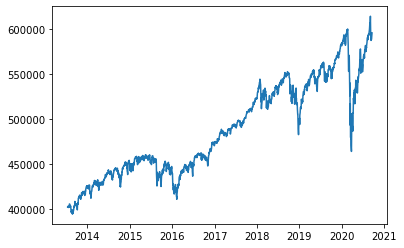

In [9]:
#not required
#Visualize the portfolio value
ptf_BM_v = ptf_BM.iloc[:, -1]
plt.plot(ptf_BM.index,ptf_BM_v)
plt.show()

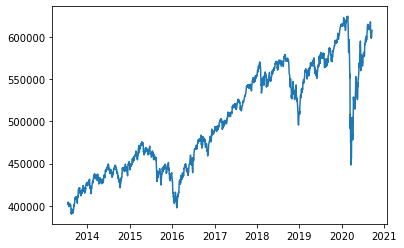

In [10]:
#not required
ptf_naive_BL_v = ptf_naive_BL.iloc[:,-1]
plt.plot(ptf_naive_BL.index, ptf_naive_BL_v)
plt.show()

In [11]:
# Compare the performance for the whole period
whole_1a = whole_fig(ptf_BM, ptf_naive_BL)
whole_1a

,Portfolio Name,Annual return,volatility,Max DD,Sharpe Ratio
1,Benchmark Portfolio,0.060757,0.103697,-0.227098,0.466853
2,Naive baseline portfolio,0.064329,0.111124,-0.282304,0.467796


In [12]:
#define a get_new_df function to separate the data into corresponding quarter
date = pd.Series(ptf_BM.index) 
quarter = date.dt.quarter
year = pd.Series(ptf_BM.index.year)
year_Q = pd.concat([year, quarter], axis = 1)
year_Q.columns = ['Year', 'Quarter']
year_Q.index = ptf_BM.index
year_Q = year_Q['Year'].map(str) + '_Q' + year_Q['Quarter'].map(str)
unique_quarter = list(set(year_Q))
unique_quarter.sort()

In [13]:
def get_new_df(ptf):
    ptf_new = pd.concat([ptf, year_Q], axis = 1)
    ptf_new['Quarter'] = ptf_new.iloc[:,-1]
    ptf_new = ptf_new.drop(ptf_new.columns[-2], axis = 1)
    
    return ptf_new

In [14]:
ptf_BM_new = get_new_df(ptf_BM)
ptf_naive_BL_new = get_new_df(ptf_naive_BL)
time_series_all_new = get_new_df(time_series_all)

In [15]:
def quarterly_fig_1(*ptf):
    d = []
    for i in unique_quarter:
        for j in range(len(ptf)):
            mean_pi = ptf[j][ptf[j].Quarter == i].iloc[:,-3].mean() *252
            std_i = ptf[j][ptf[j].Quarter == i].iloc[:,-3].std() * math.sqrt(252)
            SR_i = (mean_pi-np.mean(time_series_all_new[time_series_all_new.Quarter ==  i].iloc[:, 6] / 100)) / std_i
            MDD_i = min(((ptf[j][ptf[j].Quarter == i].iloc[:,-2].dropna()[::-1].cummin())-(ptf[j][ptf[j].Quarter == i].iloc[:,-2].dropna().cummax()))/(ptf[j][ptf[j].Quarter == i].iloc[:,-2].dropna().cummax()))
            
            #roll_max = ptf[j].iloc[:,-2].rolling(min_periods = 1, window = 252).max()
            #daily_dd = ptf[j].iloc[:,-2] / roll_max - 1
            #MDD_i = daily_dd.rolling(min_periods = 1, window = 252).min()
            d.append({'Return' : mean_pi, 
                      'stdev' : std_i, 
                      'SR' : SR_i,
                      'MDD' : MDD_i})
            index = [np.array(np.repeat(unique_quarter,len(ptf))), np.array([q+1 for q in range(len(ptf))] * 29)]

    return pd.DataFrame(d, index = index)

In [16]:
quarter_1a = quarterly_fig_1(ptf_BM_new, ptf_naive_BL_new)
quarter_1a.head()

Return     stdev        SR       MDD
2013_Q3 1  0.028819  0.056129  0.509427 -0.027343
        2  0.088447  0.080431  1.096860 -0.034702
2013_Q4 1  0.217754  0.064077  3.390472 -0.015948
        2  0.186205  0.076936  2.413728 -0.022658
2014_Q1 1  0.037717  0.074417  0.501524 -0.034286

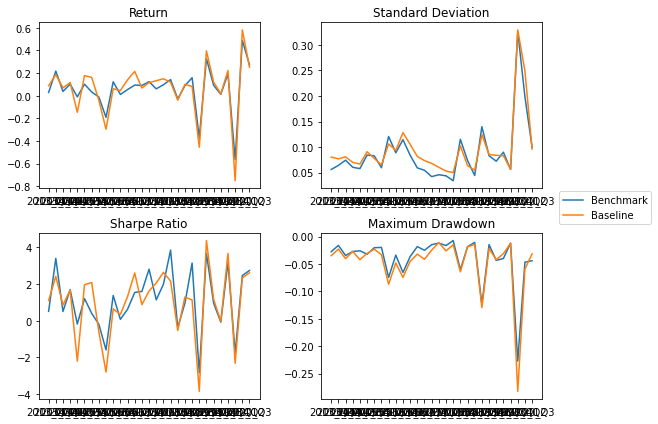

In [17]:
# visualize the comparison of quarter figures
# need to change x axis
re_BM = quarter_1a['Return'][:,1]
re_BL = quarter_1a['Return'][:,2]
std_BM = quarter_1a['stdev'][:,1]
std_BL = quarter_1a['stdev'][:,2]
sr_BM = quarter_1a['SR'][:,1]
sr_BL = quarter_1a['SR'][:,2]
MDD_BM = quarter_1a['MDD'][:,1]
MDD_BL = quarter_1a['MDD'][:,2]

fig, axs = plt.subplots(2, 2, figsize = (8, 6))
axs[0, 0].plot(re_BM)
axs[0, 0].plot(re_BL)
axs[0, 0].set_title('Return')

axs[0, 1].plot(std_BM)
axs[0, 1].plot(std_BL)
axs[0, 1].set_title('Standard Deviation')

axs[1, 0].plot(sr_BM)
axs[1, 0].plot(sr_BL)
axs[1, 0].set_title('Sharpe Ratio')

axs[1, 1].plot(MDD_BM)
axs[1, 1].plot(MDD_BL)
axs[1, 1].set_title('Maximum Drawdown')

line_labels = ['Benchmark', 'Baseline']
fig.legend(labels= line_labels, bbox_to_anchor=(1.15, 0.55), borderaxespad=0.1)
fig.tight_layout()

In [18]:
# How did the portfolio perform during the recent Corona crisis from February 20th 2020 until March 23rd 2020, compared to the benchmark
# Compare performance among different portfolios within corona period
def corona_fig(*ptf):
    d = []
    for t, i in zip(ptf, range(len(ptf))):
        mean_pi = float(t.iloc[1660:1683,-2].mean()) *252
        std_i = t.iloc[1660:1683,-2].std() * math.sqrt(252)
        MDD_i = min(((t.iloc[1660:1683,-1].dropna()[::-1].cummin())-(t.iloc[1660:1683,-1].dropna().cummax()))/(t.iloc[1660:1683,-1].dropna().cummax()))
        SR_i = (float(t.iloc[1660:1683,-2].mean()) *252 - np.mean(time_series_all.iloc[4316:4339, 6] / 100))/(t.iloc[1660:1683,-2].std() * math.sqrt(252))
        #data = [mean_pi, std_i, MDD_i, SR_i]
        d.append({'Annual return' : mean_pi,
                  'volatility' : std_i,
                  'Max DD' : MDD_i,
                  'Sharpe Ratio' : SR_i})
    return pd.DataFrame(d, index = [i + 1 for i in range(len(ptf))])


In [19]:
# Corona period
# the MDD from whole period comes from corona time?
corona_1a = corona_fig(ptf_BM, ptf_naive_BL)
corona_1a

,Annual return,volatility,Max DD,Sharpe Ratio
1,-2.702824,0.463287,-0.225748,-5.848791
2,-3.298801,0.456499,-0.282304,-7.241307


In [20]:
# crosscheck the MDD calculated from above
min((ptf_naive_BL.iloc[1660:1683,-1].dropna()[::-1].cummin() - ptf_naive_BL.iloc[1660:1683,-1].dropna().cummax()) / ptf_naive_BL.iloc[1660:1683,-1].dropna().cummax())

-0.2823040097084852

In [21]:
# How did the portfolio perform during the recent Corona crisis compared to the benchmark?
print('Worse return and sharpe ratio, similar volatile and less MDD')

Worse return and sharpe ratio, similar volatile and less MDD


QUES 1(b)

With the baseline US equity factor portfolio and its benchmark being calculated in part (a) now we back test alternative portfolio allocation methods
that might have performed better than the simple baseline factor portfolio, compared to the benchmark. Hence instead of the fixed-weights of a 60%/40%
portfolio allocation, and within the equity part for the five factor ETFs each, calculate the portfolio weights using the Markowitz portfolio theory
to determine the maximum Sharpe-ratio (MSR) portfolio, the minimum volatility (MinV) portfolio and the simple 1/N portfolio, with N=12 ETFs. Again
assume monthly portfolio rebalancing. Calculate for these factor portfolios the annualized returns, Sharpe ratio, and volatility as well as the
rolling maximum drawdown from July 18th 2013 until September 16th 2019, and also for each quarter ending March, June, September and December. Do the
more complicated portfolio allocation methods produce superior performance results compared to the baseline factor portfolio the “naïve” baseline
portfolio from exercise 1 and the benchmark portfolio? Elaborate in which way the alternative factor portfolios perform differently than the baseline
portfolio. How do the portfolio weights evolve when applying the Markowitz portfolio theory

In [22]:
#install package for MSR and MIN weightings
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [23]:
#1b
#MSR weight
VCV_ret = ptf_naive_BL.iloc[1:, :8]
VCV_1 = pypfopt.risk_models.sample_cov(VCV_ret, returns_data=True, frequency=252)
VCV_in = np.linalg.inv(VCV_1)
mu = pypfopt.expected_returns.mean_historical_return(VCV_ret, returns_data= True, frequency=252)
ones_array = np.ones(8) 

In [24]:
#weight with package for MSR
from pypfopt import objective_functions, base_optimizer
ef_msr = EfficientFrontier(mu, VCV_1, weight_bounds=(-2, 2))
sharpe_pfolio=ef_msr.max_sharpe() 
Wmsr_1 = ef_msr.clean_weights()
Wmsr_1 = [0.46764, 0.03989, -0.1866, 0.22695, 1.0531, -1.18876, 0.14542, 0.44237]
ptf_msr_1 = get_df(ptf_col, Wmsr_1, columns, 8, 2656)
ptf_msr_1.name = 'Maximum Sharpe Ratio_1'
ptf_msr_1_new = pd.concat([ptf_msr_1, year_Q], axis = 1)
ptf_msr_1_new['Quarter'] = ptf_msr_1_new.iloc[:,-1]
ptf_msr_1_new = ptf_msr_1_new.drop(ptf_msr_1_new.columns[-2], axis = 1)
ptf_msr_1.name = 'Maximum Sharpe Ratio_1' 

In [25]:
ef_msr.portfolio_performance(verbose = True, risk_free_rate = np.mean(time_series_all.iloc[:, 6] / 100))

Expected annual return: 11.9%
Annual volatility: 13.5%
Sharpe Ratio: 0.79


(0.11868721875850413, 0.1347601135718338, 0.7891145345609661)

In [26]:
#MIN with pyportfolioOpt
ef_min = EfficientFrontier(mu, VCV_1, weight_bounds=(-2,2))
Min_ptf = ef_min.min_volatility()
clean_MIN = ef_min.clean_weights()

In [27]:
ef_min.portfolio_performance(verbose = True, risk_free_rate = np.mean(time_series_all.iloc[:, 6] / 100))

Expected annual return: 2.5%
Annual volatility: 3.1%
Sharpe Ratio: 0.41


(0.02529688239698368, 0.031220588045980407, 0.4148169124177498)

In [28]:
#Min weight
Wmin_1 = np.dot(VCV_in, ones_array.T) / np.dot(ones_array, (np.dot(VCV_in, ones_array.T)))
ptf_min_1 = get_df(ptf_col, Wmin_1, columns, 8, 2656)
ptf_min_1.name = 'Mininimum Volatility_1'
ptf_min_1_new = pd.concat([ptf_min_1, year_Q], axis = 1)
ptf_min_1_new['Quarter'] = ptf_min_1_new.iloc[:,-1]
ptf_min_1_new = ptf_min_1_new.drop(ptf_min_1_new.columns[-2], axis = 1)
ptf_msr_1_new.name = 'Maximum Sharpe Ratio_1'

In [29]:
#1/n weight
n_weight_1 = [1/8 for i in range(1, 9)]
ptf_n_1 = get_df(ptf_col, n_weight_1, columns, 8, 2656)
ptf_n_1.name = '1/N weighted_1'
ptf_n_1_new = pd.concat([ptf_n_1, year_Q], axis = 1)
ptf_n_1_new['Quarter'] = ptf_n_1_new.iloc[:,-1]
ptf_n_1_new = ptf_n_1_new.drop(ptf_n_1_new.columns[-2], axis = 1)

In [30]:
#Compare the performance for MSR, MIN, and 1/n portdolios
whole_1b = whole_fig(ptf_BM, ptf_naive_BL, ptf_msr_1, ptf_min_1, ptf_n_1)
whole_1b

,Portfolio Name,Annual return,volatility,Max DD,Sharpe Ratio
1,Benchmark Portfolio,0.060757,0.103697,-0.227098,0.466853
2,Naive baseline portfolio,0.064329,0.111124,-0.282304,0.467796
3,Maximum Sharpe Ratio_1,0.122206,0.136549,-0.291525,0.804546
4,Mininimum Volatility_1,0.023719,0.031546,-0.070242,0.360513
5,1/N weighted_1,0.058793,0.083735,-0.228091,0.554688


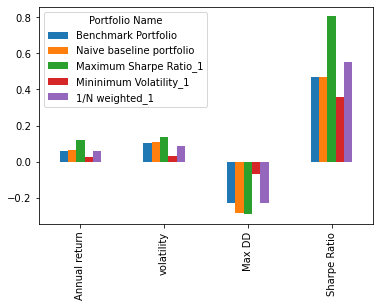

In [31]:
# What do you observe?
# cols = whole_1b.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# whole_1b = whole_1b[cols]
whole_1b.round(4).set_index('Portfolio Name').T.plot(kind='bar')
plt.show()

In [32]:
quarter_1b = quarterly_fig_1(ptf_BM_new, ptf_naive_BL_new, ptf_msr_1_new, ptf_min_1_new, ptf_n_1_new)
quarter_1b.head()

Return     stdev        SR       MDD
2013_Q3 1  0.028819  0.056129  0.509427 -0.027343
        2  0.088447  0.080431  1.096860 -0.034702
        3 -0.025715  0.140022 -0.185266 -0.084569
        4  0.014525  0.028967  0.493640 -0.016188
        5  0.074323  0.073288  1.011037 -0.037997

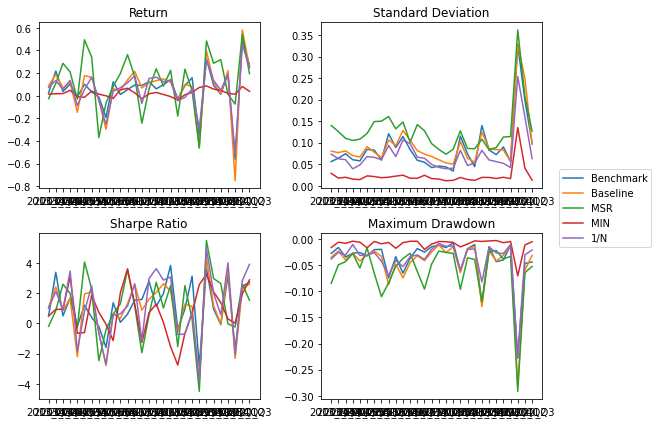

In [33]:
# visualize the comparison of quarter figures
# need to change x axis
re = pd.concat([quarter_1b['Return'][:,1], quarter_1b['Return'][:,2], quarter_1b['Return'][:,3], quarter_1b['Return'][:,4], quarter_1b['Return'][:,5]], axis = 1)
std = pd.concat([quarter_1b['stdev'][:,1], quarter_1b['stdev'][:,2], quarter_1b['stdev'][:,3], quarter_1b['stdev'][:,4], quarter_1b['stdev'][:,5]], axis = 1)
sr = pd.concat([quarter_1b['SR'][:,1], quarter_1b['SR'][:,2], quarter_1b['SR'][:,3], quarter_1b['SR'][:,4], quarter_1b['SR'][:,5]], axis = 1)
MDD = pd.concat([quarter_1b['MDD'][:,1], quarter_1b['MDD'][:,2], quarter_1b['MDD'][:,3], quarter_1b['MDD'][:,4], quarter_1b['MDD'][:,5]], axis = 1)

fig, axs = plt.subplots(2, 2, figsize = (8, 6))
axs[0, 0].plot(re)
axs[0, 0].set_title('Return')

axs[0, 1].plot(std)
axs[0, 1].set_title('Standard Deviation')

axs[1, 0].plot(sr)
axs[1, 0].set_title('Sharpe Ratio')

axs[1, 1].plot(MDD)
axs[1, 1].set_title('Maximum Drawdown')

line_labels = ['Benchmark', 'Baseline', 'MSR', 'MIN', '1/N']
fig.legend(labels= line_labels, bbox_to_anchor=(1.15, 0.6), borderaxespad=0.1)
fig.tight_layout()

QUES 2)
 
Given the baseline portfolio and alternative portfolio allocation using classic ETFs that cover broad segment of the equity and bond markets,
the next step is to take a closer look at factor investing to optimize the exposure to equity risk factors for US stocks. Hence instead of the ETF on
the Russel 2000, which accounts for 70% in the 60% equity allocation, the five US equity factor ETFs on momentum, size, value, quality and minimum
volatility are used.

a) As a baseline factor portfolio replace the US equity part, represented by the Russell 2000 ETF, with equally weighting the five factor ETFs.
The rest of the baseline portfolio is unchanged. The data is again the price time series from July 18th 2013 until September 16th 2019. Assume monthly
portfolio rebalancing. How does this baseline US equity factor portfolio perform compared to the “naïve” baseline portfolio from exercise 1, measured
by the annualized returns, volatility, Sharpe-ratio and rolling maximum drawdowns, as well as compared to the benchmark portfolio?

In [34]:
#2a
ptf_col_etf = np.r_[17:22, 10:17]
initial_weight_etf = np.array([0.084, 0.084, 0.084, 0.084, 0.084, 0.06, 0.06, 0.06, 0.1, 0.1, 0.1, 0.1])
columns_etf = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8','w9','w10','w11','w12']

ptf_etf = get_df(ptf_col_etf, initial_weight_etf, columns_etf, 12, 2656)
ptf_etf.name = 'Equally weighted ETF Portfolio'

In [35]:
# Compare performance of Benchmark, baseline, and equity factor portfolios
whole_2a = whole_fig(ptf_BM, ptf_naive_BL, ptf_etf)
whole_2a

,Portfolio Name,Annual return,volatility,Max DD,Sharpe Ratio
1,Benchmark Portfolio,0.060757,0.103697,-0.227098,0.466853
2,Naive baseline portfolio,0.064329,0.111124,-0.282304,0.467796
3,Equally weighted ETF Portfolio,0.080615,0.095701,-0.245645,0.713357


QUES 2 

b) With the baseline US equity factor portfolio and its benchmark being calculated in part (a) now we back test alternative portfolio allocation
methods that might have performed better than the simple baseline factor portfolio, compared to the benchmark. Hence instead of the fixed-weights of a
60%/40% portfolio allocation, and within the equity part for the five factor ETFs each, calculate the portfolio weights using the Markowitz portfolio
theory to determine the maximum Sharpe-ratio (MSR) portfolio, the minimum volatility (MinV) portfolio and the simple 1/N portfolio, with N=12 ETFs.
Again assume monthly portfolio rebalancing. Calculate for these factor portfolios the annualized returns, Sharpe ratio, and volatility as well as the
rolling maximum drawdown from July 18th 2013 until September 16th 2019, and also for each quarter ending March, June, September and December. Do the
more complicated portfolio allocation methods produce superior performance results compared to the baseline factor portfolio the “naïve” baseline
portfolio from exercise 1 and the benchmark portfolio? Elaborate in which way the alternative factor portfolios perform differently than the baseline
portfolio. How do the portfolio weights evolve when applying the Markowitz portfolio theory?

In [36]:
#2b
#MSR weight
VCV_ret_2 = ptf_etf.iloc[1:, :12]
VCV_2 = pypfopt.risk_models.sample_cov(VCV_ret_2, returns_data=True, frequency=252)
VCV_in_2 = np.linalg.inv(VCV_2)
mu_2 = pypfopt.expected_returns.mean_historical_return(VCV_ret_2, returns_data= True, frequency=252)
ones_array_2 = np.ones(12)  

In [37]:
#calculate from Excel
#Wmsr_2_x = np.dot(VCV_in_2, mu_2.T) / np.dot(ones_array_2, (np.dot(VCV_in_2, mu_2.T)))

In [38]:
#MSR with pyportfolioOpt
from pypfopt import objective_functions, base_optimizer
ef_msr_2 = EfficientFrontier(mu_2, VCV_2, weight_bounds=(-2,2))
msr_ptf_2=ef_msr_2.max_sharpe() 
Wmsr_2=ef_msr_2.clean_weights()
Wmsr_2 = [0.92477, 0.60708, -1.30853, 2.0, -0.32853, -0.05301, -0.69024, 0.23884, 1.1599, -1.21048, -0.80254, 0.46273]
ptf_msr_2 = get_df(ptf_col_etf, Wmsr_2, columns_etf, 12, 2656)
ptf_msr_2.name = 'Maximum Sharpe Ratio_2'
#get new df with quater at the last column
ptf_msr_2_new = pd.concat([ptf_msr_2, year_Q], axis = 1)
ptf_msr_2_new['Quarter'] = ptf_msr_2_new.iloc[:,-1]
ptf_msr_2_new = ptf_msr_2_new.drop(ptf_msr_2_new.columns[-2], axis = 1)

In [39]:
ef_msr_2.portfolio_performance(verbose = True, risk_free_rate = np.mean(time_series_all.iloc[:, 6] / 100))

Expected annual return: 37.5%
Annual volatility: 25.0%
Sharpe Ratio: 1.45


(0.37480824419102343, 0.24991791564923616, 1.4503249548538226)

In [40]:
#MIN with pyportfolioOpt
ef_min_2 = EfficientFrontier(mu_2, VCV_2, weight_bounds=(-2,2))
Min_ptf_2 = ef_min_2.min_volatility()
clean_MIN_2 = ef_min_2.clean_weights()
print(clean_MIN_2)

OrderedDict([('iShares Edge MSCI USA Momentum Factor ETF (MTUM) $', 0.01936), ('iShares Edge MSCI USA Size Factor ETF (SIZE) $', -0.07405), ('iShares Edge MSCI USA Value Factor ETF (VLUE) $', 0.01892), ('iShares Edge MSCI USA Quality Factor ETF (QUAL) $', 0.0031), ('iShares Edge MSCI Min Vol USA ETF (USMV) $', -0.00924), ('iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) €', -0.01168), ('iShares MSCI Emerging Markets ETF (EEM) $', -0.03501), ('iShares Core Nikkei 225 ETF (1329.T) ¥', 0.03292), ('iShares 20+ Year Treasury Bond ETF (TLT) $', -0.17476), ('iShares Core U.S. Aggregate Bond ETF (AGG) $', 1.30051), ('SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $', 0.19019), ('iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $', -0.26025)])


In [41]:
ef_min_2.portfolio_performance(verbose = True, risk_free_rate = np.mean(time_series_all.iloc[:, 6] / 100))

Expected annual return: 2.4%
Annual volatility: 3.1%
Sharpe Ratio: 0.39


(0.024388724121433954, 0.031038104667506426, 0.3879962965057517)

In [42]:
Wmin_2 = np.dot(VCV_in_2, ones_array_2.T) / np.dot(ones_array_2, (np.dot(VCV_in_2, ones_array_2.T)))
ptf_min_2 = get_df(ptf_col_etf, Wmin_2, columns_etf, 12, 2656)
ptf_min_2.name = 'Mininimum Volatility_2'
ptf_min_2_new = pd.concat([ptf_min_2, year_Q], axis = 1)
ptf_min_2_new['Quarter'] = ptf_min_2_new.iloc[:,-1]
ptf_min_2_new = ptf_min_2_new.drop(ptf_min_2_new.columns[-2], axis = 1)

In [43]:
n_weight_2 = [1/12 for i in range(1, 13)]
ptf_n_2 = get_df(ptf_col_etf, n_weight_2, columns_etf, 12, 2656)
ptf_n_2.name = '1/N weighted_2'
ptf_n_2_new = pd.concat([ptf_n_2, year_Q], axis = 1)
ptf_n_2_new['Quarter'] = ptf_n_2_new.iloc[:,-1]
ptf_n_2_new = ptf_n_2_new.drop(ptf_n_2_new.columns[-2], axis = 1)

In [44]:
#Compare the performance for MSR, MIN, and 1/n portfolios
whole_2b = whole_fig(ptf_BM, ptf_naive_BL, ptf_etf, ptf_msr_2, ptf_min_2, ptf_n_2)
whole_2b

,Portfolio Name,Annual return,volatility,Max DD,Sharpe Ratio
1,Benchmark Portfolio,0.060757,0.103697,-0.227098,0.466853
2,Naive baseline portfolio,0.064329,0.111124,-0.282304,0.467796
3,Equally weighted ETF Portfolio,0.080615,0.095701,-0.245645,0.713357
4,Maximum Sharpe Ratio_2,0.332284,0.246056,-0.284394,1.300263
5,Mininimum Volatility_2,0.023067,0.031325,-0.069601,0.342259
6,1/N weighted_2,0.080114,0.102716,-0.262981,0.659755


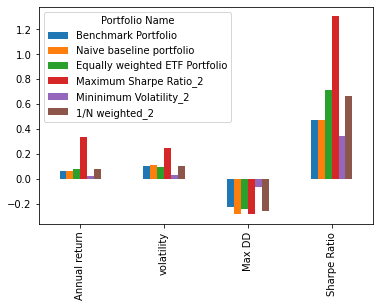

In [45]:
# cols_2 = whole_2b.columns.tolist()
# cols_2 = cols_2[-1:] + cols_2[:-1]
# whole_2b = whole_2b[cols_2]
whole_2b.round(4).set_index('Portfolio Name').T.plot(kind='bar')
plt.show()

In [46]:
quarter_2b = quarterly_fig_1(ptf_BM_new, ptf_naive_BL_new, get_new_df(ptf_etf), ptf_msr_2_new, ptf_min_2_new, ptf_n_2_new)
quarter_2b.head(6)

Return     stdev        SR       MDD
2013_Q3 1  0.028819  0.056129  0.509427 -0.027343
        2  0.088447  0.080431  1.096860 -0.034702
        3  0.034384  0.061741  0.553248 -0.031974
        4  0.008956  0.234538  0.037224 -0.104573
        5  0.017822  0.029320  0.600124 -0.017011
        6  0.049419  0.067065  0.733525 -0.032640

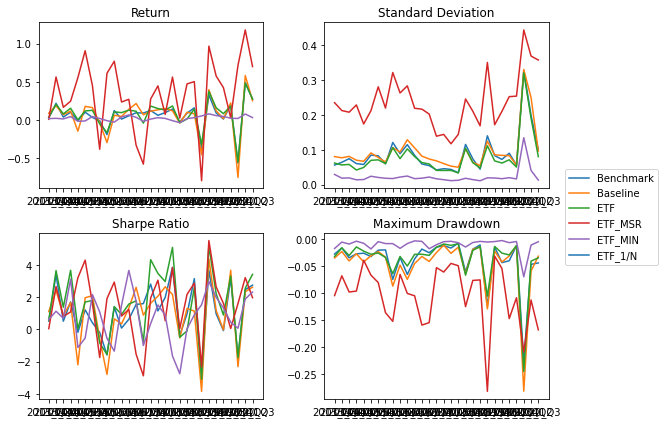

In [47]:
# visualize the comparison of quarter figures
# need to change x axis
re_2b = pd.concat([quarter_2b['Return'][:,1], quarter_2b['Return'][:,2], quarter_2b['Return'][:,3], quarter_2b['Return'][:,4], quarter_2b['Return'][:,5]], axis = 1)
std_2b = pd.concat([quarter_2b['stdev'][:,1], quarter_2b['stdev'][:,2], quarter_2b['stdev'][:,3], quarter_2b['stdev'][:,4], quarter_2b['stdev'][:,5]], axis = 1)
sr_2b = pd.concat([quarter_2b['SR'][:,1], quarter_2b['SR'][:,2], quarter_2b['SR'][:,3], quarter_2b['SR'][:,4], quarter_2b['SR'][:,5]], axis = 1)
MDD_2b = pd.concat([quarter_2b['MDD'][:,1], quarter_2b['MDD'][:,2], quarter_2b['MDD'][:,3], quarter_2b['MDD'][:,4], quarter_2b['MDD'][:,5]], axis = 1)

fig, axs = plt.subplots(2, 2, figsize = (8, 6))
axs[0, 0].plot(re_2b)
axs[0, 0].set_title('Return')

axs[0, 1].plot(std_2b)
axs[0, 1].set_title('Standard Deviation')

axs[1, 0].plot(sr_2b)
axs[1, 0].set_title('Sharpe Ratio')

axs[1, 1].plot(MDD_2b)
axs[1, 1].set_title('Maximum Drawdown')

line_labels = ['Benchmark', 'Baseline', 'ETF', 'ETF_MSR', 'ETF_MIN', 'ETF_1/N']
fig.legend(labels= line_labels, bbox_to_anchor=(1.15, 0.6), borderaxespad=0.1)
fig.tight_layout()

QUES 2

c) It is observed that the value factor, representing cheap stocks, is outperformed since the financial crisis by growth stocks with a high
momentum, which are often stocks with a high momentum in booming industries like internet & technology stocks. Hence analyze from July 18th 2013 until
September 16th 2020 the performance of the US value factor compared to the US momentum factor according to their annualized returns, volatility,
Sharpe-ratios and maximum drawdowns. Do you also observe the underperformance of the value factor the researchers from AQR observed?

In [48]:
#2c
#Performance indicators for Momentum ETF
aqr_comp_moment = []
mean_pi_aqr_moment = float(ptf_msr_2_new.iloc[:,0].mean()) *252
std_i_aqr_moment = ptf_msr_2_new.iloc[:,0].std() * math.sqrt(252)
# (1 + ptf_msr_2_new.iloc[:,0]).cumprod()
MDD_i_aqr_moment = min((((1 + ptf_msr_2_new.iloc[:,0]).cumprod().dropna()[::-1].cummin())-((1 + ptf_msr_2_new.iloc[:,0]).cumprod().dropna().cummax()))/((1 + ptf_msr_2_new.iloc[:,0]).cumprod().dropna().cummax()))
SR_i_aqr_moment = (float(ptf_msr_2_new.iloc[:,0].mean()) *252 - np.mean(time_series_all.iloc[:, 6] / 100))/(ptf_msr_2_new.iloc[:,0].std() * math.sqrt(252))
aqr_comp_moment.append({'ETF' : 'USA Momentum Factor ETF',
          'Annual return' : mean_pi_aqr_moment,
          'Volatility' : std_i_aqr_moment, 
          'MDD' : MDD_i_aqr_moment,                 
          'Sharpe Ratio' : SR_i_aqr_moment})
aqr_comp_moment_df = pd.DataFrame(aqr_comp_moment)


In [49]:
#Performance indicators for Value ETF
aqr_comp_value = []
mean_pi_aqr_value = float(ptf_msr_2_new.iloc[:,2].mean()) *252
std_i_aqr_value = ptf_msr_2_new.iloc[:,2].std() * math.sqrt(252)
# (1 + ptf_msr_2_new.iloc[:,0]).cumprod()
MDD_i_aqr_value = min((((1 + ptf_msr_2_new.iloc[:,2]).cumprod().dropna()[::-1].cummin())-((1 + ptf_msr_2_new.iloc[:,2]).cumprod().dropna().cummax()))/((1 + ptf_msr_2_new.iloc[:,2]).cumprod().dropna().cummax()))
SR_i_aqrt_value = (float(ptf_msr_2_new.iloc[:,2].mean()) *252 - np.mean(time_series_all.iloc[:, 6] / 100))/(ptf_msr_2_new.iloc[:,2].std() * math.sqrt(252))
aqr_comp_value.append({'ETF' : 'USA Value Factor ETF',
          'Annual return' : mean_pi_aqr_value,
          'Volatility' : std_i_aqr_value, 
          'MDD' : MDD_i_aqr_value,                 
          'Sharpe Ratio' : SR_i_aqrt_value})
aqr_comp_value_df = pd.DataFrame(aqr_comp_value)

In [50]:
#Combined performance indicators for value and momentum ETF
aqr_comp = aqr_comp_moment_df.append(aqr_comp_value_df)
aqr_comp.round(5)

,ETF,Annual return,Volatility,MDD,Sharpe Ratio
0,USA Momentum Factor ETF,0.17045,0.18781,-0.34082,0.84183
0,USA Value Factor ETF,0.08701,0.19234,-0.39471,0.38818


QUES 3

After having analyzed potential portfolio composition using classic ETFs that represent broad segment of the markets for equities and bonds,
as well as looking into potential equity factors, one might mix the portfolio also with liquid alternative assets. The alternative assets that might
improve the retirement portfolio’s performance are listed US real estate companies in the form of “Real Estate Investment Trusts” (REIT), Multi-
strategy hedge-funds, global infrastructure companies and global private-equity firms. To invest at low costs into these alternative assets the ETFs
shown in columns X to AA in the worksheet “ETF & FF Factor Time Series” are to be used. The important aspect is that these ETFs track the returns of
stocks of companies investing in alternative assets, and not the returns of the alternative assets themselves.

a) Starting with the “naïve” baseline portfolio from exercise 1 the international equity part, the 30% in the 60% equity allocation, are
replaced with equal weights in the four liquid alternative ETFs. Again assume monthly rebalancing, use the price date time series from July 18th 2013
until September 16th 2019, and calculate the annualized returns, volatility, Sharpe-ration and rolling maximum drawdown. How does with a portfolio
perform compared to the baseline portfolio, and its benchmark? Do alternative assets in this baseline comparison offer some insights into their
performance properties compared to regular broad market ETFs? How correlated are the liquid alternatives on an annual basis compared to a broad equity
index like the Wilshire 5000 Total Market Index (W5000)?

In [51]:
#3a
ptf_col_alter = np.r_[8, 22:26, 13:17]
initial_weight_alter = np.array([0.42, 0.045, 0.045, 0.045, 0.045, 0.1, 0.1, 0.1, 0.1])
columns_alter = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8','w9']
ptf_alter = get_df(ptf_col_alter, initial_weight_alter, columns_alter, 9, 2656)
ptf_alter.name = 'Alternative Portfolio'

In [52]:
# Compare performance of Benchmark, baseline, and alternative portfolios
whole_3a = whole_fig(ptf_BM, ptf_naive_BL, ptf_alter)
whole_3a

,Portfolio Name,Annual return,volatility,Max DD,Sharpe Ratio
1,Benchmark Portfolio,0.060757,0.103697,-0.227098,0.466853
2,Naive baseline portfolio,0.064329,0.111124,-0.282304,0.467796
3,Alternative Portfolio,0.063588,0.114605,-0.292193,0.447113


In [53]:
# How correlated are the liquid alternatives on an annual basis compared to a broad equity index like the Wilshire 5000 Total Market Index (W5000)? 
ptf_alter['return_m'].corr(ptf_BM['Wilshire 5000 Total Market Index (^W5000) $'])

0.9010401806769802

QUES 3

b) Now instead of the fixed-weights of a 60%/40% portfolio allocation, and within the international equity part with the four liquid
alternatives ETFs each, calculate the portfolio weights using the Markowitz portfolio theory to determine the maximum Sharpe-ratio (MSR) portfolio,
the minimum volatility (MinV) portfolio and the simple 1/N portfolio, with N=9 ETFs. Again assume monthly portfolio rebalancing. Calculate for these
liquid alternatives portfolios the annualized returns, Sharpe ratio, and volatility as well as the rolling maximum drawdown from July 18th 2013 until
September 16th 2019, and also for each quarter ending March, June, September and December. Do the more complicated portfolio allocation methods
produce superior performance results compared to the baseline liquid alternative portfolio, the “naïve” baseline portfolio from exercise 1 and the
benchmark portfolio? Elaborate in which way the liquid alternatives portfolios perform differently than the baseline portfolios and whether liquid
alternatives do improve portfolio performance. How do the portfolio weights evolve when applying the Markowitz portfolio theory?

In [54]:
#3b
#MSR weight
VCV_ret_3 = ptf_alter.iloc[1:, :9]
VCV_3 = pypfopt.risk_models.sample_cov(VCV_ret_3, returns_data=True, frequency=252)
VCV_in_3 = np.linalg.inv(VCV_3)
mu_3 = pypfopt.expected_returns.mean_historical_return(VCV_ret_3, returns_data= True, frequency=252)
ones_array_3 = np.ones(9)
#Wmsr_3 = np.dot(VCV_in_3, mu_3.T) / np.dot(ones_array_3, (np.dot(VCV_in_3, mu_3.T)))

In [55]:
#MSR weight
ef_msr_3 = EfficientFrontier(mu_3, VCV_3, weight_bounds=(-2,2))
msr_ptf_3=ef_msr_3.max_sharpe() 
clean_msr_3=ef_msr_3.clean_weights()
Wmsr_3 = [0.83204, -0.29187, -2.0, -0.3291, 0.54791, 1.4586, -0.85648, 0.68273, 0.95615]
ptf_msr_3 = get_df(ptf_col_alter, Wmsr_3, columns_alter, 9, 2656)
ptf_msr_3.name = 'Maximum Sharpe Ratio_3'
#get new df with quater at the last column
ptf_msr_3_new = pd.concat([ptf_msr_3, year_Q], axis = 1)
ptf_msr_3_new['Quarter'] = ptf_msr_3_new.iloc[:,-1]
ptf_msr_3_new = ptf_msr_3_new.drop(ptf_msr_3_new.columns[-2], axis = 1)

In [56]:
ef_msr_3.portfolio_performance(verbose = True, risk_free_rate = np.mean(time_series_all.iloc[:, 6] / 100))

Expected annual return: 19.2%
Annual volatility: 21.7%
Sharpe Ratio: 0.83


(0.1923268884069563, 0.217088178836945, 0.8290678696155832)

In [57]:
#Min weight
Wmin_3 = np.dot(VCV_in_3, ones_array_3.T) / np.dot(ones_array_3, (np.dot(VCV_in_3, ones_array_3.T)))
ptf_min_3 = get_df(ptf_col_alter, Wmin_3, columns_alter, 9, 2656)
ptf_min_3.name = 'Mininimum Volatility_3'
ptf_min_3_new = pd.concat([ptf_min_3, year_Q], axis = 1)
ptf_min_3_new['Quarter'] = ptf_min_3_new.iloc[:,-1]
ptf_min_3_new = ptf_min_3_new.drop(ptf_min_3_new.columns[-2], axis = 1)

In [58]:
#MIN with pyportfolioOpt
ef_min_3 = EfficientFrontier(mu_3, VCV_3, weight_bounds=(-2,2))
Min_ptf_3 = ef_min_3.min_volatility()
clean_MIN_3 = ef_min_3.clean_weights()
print(clean_MIN_3)

OrderedDict([('iShares Russell 2000 ETF (IWM) $', -0.02352), ('iShares Core U.S. REIT ETF (USRT) $', -0.0082), ('IQ Hedge Multi-Strategy Tracker ETF (QAI) $', 0.4637), ('iShares Global Infrastructure ETF (IGF) $', -0.0718), ('Invesco Global Listed Private Equity ETF (PSP) $', -0.08989), ('iShares 20+ Year Treasury Bond ETF (TLT) $', -0.14026), ('iShares Core U.S. Aggregate Bond ETF (AGG) $', 0.93829), ('SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $', 0.15735), ('iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $', -0.22567)])


In [59]:
pd.DataFrame(Wmsr_3)

,0
0,0.83204
1,-0.29187
2,-2.00000
3,-0.32910
4,0.54791
5,1.45860
6,-0.85648
7,0.68273
8,0.95615


In [60]:
ef_min_3.portfolio_performance(verbose = True, risk_free_rate = np.mean(time_series_all.iloc[:, 6] / 100))

Expected annual return: 1.7%
Annual volatility: 2.5%
Sharpe Ratio: 0.20


(0.017289515912438137, 0.024642947664460072, 0.20060349597235866)

In [61]:
#1/n weight
n_weight_3 = [1/9 for i in range(1, 10)]
ptf_n_3 = get_df(ptf_col_alter, n_weight_3, columns_alter, 9, 2656)
ptf_n_3.name = '1/N weighted_3'
ptf_n_3_new = pd.concat([ptf_n_3, year_Q], axis = 1)
ptf_n_3_new['Quarter'] = ptf_n_3_new.iloc[:,-1]
ptf_n_3_new = ptf_n_3_new.drop(ptf_n_3_new.columns[-2], axis = 1)

In [62]:
#Compare the performance for MSR, MIN, and 1/n portdolios
whole_3b = whole_fig(ptf_BM, ptf_naive_BL, ptf_alter, ptf_msr_3, ptf_min_3, ptf_n_3)
whole_3b

,Portfolio Name,Annual return,volatility,Max DD,Sharpe Ratio
1,Benchmark Portfolio,0.060757,0.103697,-0.227098,0.466853
2,Naive baseline portfolio,0.064329,0.111124,-0.282304,0.467796
3,Alternative Portfolio,0.063588,0.114605,-0.292193,0.447113
4,Maximum Sharpe Ratio_3,0.194702,0.225164,-0.434108,0.809882
5,Mininimum Volatility_3,0.014496,0.025823,-0.040014,0.083264
6,1/N weighted_3,0.056562,0.091977,-0.258741,0.480724


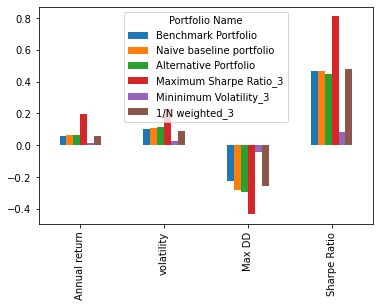

In [63]:
whole_3b.round(4).set_index('Portfolio Name').T.plot(kind='bar')
plt.show()

In [64]:
#compare performance for each quarter
quarter_3b = quarterly_fig_1(ptf_BM_new, ptf_naive_BL_new, get_new_df(ptf_alter), ptf_msr_3_new, ptf_min_3_new, ptf_n_3_new)
quarter_3b.head(6)

Return     stdev        SR       MDD
2013_Q3 1  0.028819  0.056129  0.509427 -0.027343
        2  0.088447  0.080431  1.096860 -0.034702
        3  0.061434  0.079839  0.766647 -0.038812
        4 -0.019708  0.266531 -0.074789 -0.118235
        5  0.016474  0.027197  0.597416 -0.010296
        6  0.019828  0.072010  0.272206 -0.040807

<ipython-input-65-a737704755ea>:12: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  axs[0,0].locator_params(tight=True, nbins=4)


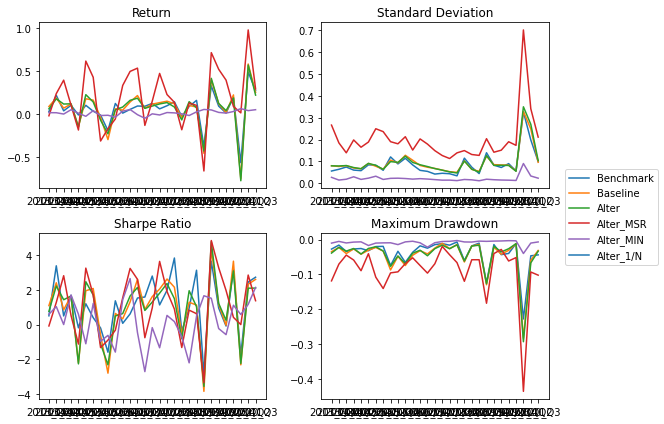

In [65]:
# visualize the comparison of quarter figures
# need to change x axis
re_3b = pd.concat([quarter_3b['Return'][:,1], quarter_3b['Return'][:,2], quarter_3b['Return'][:,3], quarter_3b['Return'][:,4], quarter_3b['Return'][:,5]], axis = 1)
std_3b = pd.concat([quarter_3b['stdev'][:,1], quarter_3b['stdev'][:,2], quarter_3b['stdev'][:,3], quarter_3b['stdev'][:,4], quarter_3b['stdev'][:,5]], axis = 1)
sr_3b = pd.concat([quarter_3b['SR'][:,1], quarter_3b['SR'][:,2], quarter_3b['SR'][:,3], quarter_3b['SR'][:,4], quarter_3b['SR'][:,5]], axis = 1)
MDD_3b = pd.concat([quarter_3b['MDD'][:,1], quarter_3b['MDD'][:,2], quarter_3b['MDD'][:,3], quarter_3b['MDD'][:,4], quarter_3b['MDD'][:,5]], axis = 1)

fig, axs = plt.subplots(2, 2, figsize = (8, 6))

axs[0, 0].plot(re_3b)
axs[0, 0].set_title('Return')
axs[0,0].locator_params(tight=True, nbins=4)

axs[0, 1].plot(std_3b)
axs[0, 1].set_title('Standard Deviation')

axs[1, 0].plot(sr_3b)
axs[1, 0].set_title('Sharpe Ratio')

axs[1, 1].plot(MDD_3b)
axs[1, 1].set_title('Maximum Drawdown')

line_labels = ['Benchmark', 'Baseline', 'Alter', 'Alter_MSR', 'Alter_MIN', 'Alter_1/N']
fig.legend(labels= line_labels, bbox_to_anchor=(1.15, 0.6), borderaxespad=0.1)
fig.tight_layout()

QUES 4

(a)
Starting with the baseline portfolio from exercise 1 (a) that uses classic ETFs for the global stock markets and US bonds predict the 20-day 95%
Value-at-Risk (VaR) and Expected Shortfall (ES) at the beginning of each month starting January 1st 2016 until September 1st 2020. Use the (i) delta-
normal or parametric approach assuming a normal distribution of the portfolio returns, (ii) historical simulation. For both methods select the
necessary past window of price data to estimate the parameters, justify your choice using verbal reasoning and statistical tools. Also test whether an
exponentially weighted moving average of the weights of the historical daily observations with a half-life of 0.5 years provides an advantage over an
equally-weighted 252 days historical rolling window when estimating the VaR and ES.

In [66]:
#Q4
import matplotlib.mlab as mlab
from scipy.stats import norm
from scipy.stats import kurtosis, skew

In [67]:
#4a
q4_trial = ptf_naive_BL.iloc[599:1796, :]
ptf_naive_BL_4 = ptf_naive_BL.iloc[368:1796, :]
mean_m = q4_trial['return_m'].resample('M').mean()[:-1]
stdev_m = q4_trial['return_m'].resample('M').std()[:-1]

In [68]:
#not helpful?
date_4 = pd.Series(ptf_naive_BL_4.index)
month_4 = date_4.dt.month
month_new = ['%02d' % i for i in month_4]
year_4 = pd.Series(ptf_naive_BL_4.index.year)
year_4 = pd.concat([year_4, pd.Series(month_new)], axis = 1)
year_4.columns = ['Year', 'Month']
year_4.index = ptf_naive_BL_4.index
year_4 = year_4['Year'].map(str) +'-' + year_4['Month'].map(str)
unique_month = list(set(year_4))
unique_month.sort()

In [69]:
index = [d for d in range(len(ptf_naive_BL_4)) if (ptf_naive_BL_4.index.month[d] - 1 == ptf_naive_BL_4.index.month[d-1] or ptf_naive_BL_4.index.month[d] - 1 == ptf_naive_BL_4.index.month[d-1] - 12)]
#add one business day 
bd = pd.tseries.offsets.BusinessDay(n = 1)

In [70]:
#Get the monthly delta VaR and ES
#if rolling window is one month, just make index[i+12] to index[i+1]
#why last 3 ES are the same?
confi = 0.05
def get_var_es(df, timeframe):
    one = []
    twenty = []
    for i in range(len(index)):
        if i <57:
            mean = df.iloc[index[i]:index[i+12], -2].mean()
            stdev = df.iloc[index[i]:index[i+12], -2].std()

            #Delta normal
            delta_var = round(norm.ppf(confi, mean, stdev), 6)
            delta_var_20d = round(delta_var * np.sqrt(20), 6)
            delta_es = round(df.iloc[index[i]:index[i+12], -2][df.iloc[index[i]:index[i+12], -2] < delta_var].mean(), 6)
            delta_es_20d = round(delta_es * np.sqrt(20), 6)

            #Historical simulation
            hist_var = round(np.percentile(df.iloc[index[i]:index[i+12], -2], 5), 6)
            hist_var_20d = round(hist_var * np.sqrt(20), 6)
            hist_es = round(df.iloc[index[i]:index[i+12], -2][df.iloc[index[i]:index[i+12], -2] < hist_var].mean(), 6)
            hist_es_20d = round(hist_es * np.sqrt(20), 6)

            day20 = [delta_var_20d, delta_es_20d, hist_var_20d, hist_es_20d]
            day1 = [delta_var, delta_es, hist_var, hist_es]
            twenty.append(day20)
            one.append(day1)
            columns = ['Delta VaR', 'Delta ES', 'Hist VaR', 'Hist ES']
            
    if timeframe == 1:
        return pd.DataFrame(one, index = mean_m.index + bd, columns = columns)
    elif timeframe == 20:
        return pd.DataFrame(twenty, index = mean_m.index + bd, columns = columns)
    #return twenty        
    #return pd.DataFrame(d, index = mean_m.index + bd, columns = ['Delta VaR 20 days', 'Delta ES 20 days', 'Hist VaR 20 days', 'Hist ES 20 days'])

In [71]:
var_es_20days = get_var_es(ptf_naive_BL_4, timeframe = 20)
var_es_20days

,Delta VaR,Delta ES,Hist VaR,Hist ES
Date,,,,
2016-01-01,-0.040992,-0.060875,-0.037700,-0.059122
2016-02-01,-0.045240,-0.061550,-0.047646,-0.063773
2016-03-01,-0.047445,-0.063003,-0.049234,-0.065271
2016-04-01,-0.047552,-0.063182,-0.048250,-0.064350
2016-05-02,-0.047534,-0.064309,-0.047677,-0.064309
2016-06-01,-0.047852,-0.064309,-0.047646,-0.064309
2016-07-01,-0.050584,-0.073437,-0.048827,-0.069873
2016-08-01,-0.050159,-0.071527,-0.049032,-0.069873
2016-09-01,-0.046117,-0.062239,-0.047646,-0.063379


In [72]:
var_es_1day = get_var_es(ptf_naive_BL_4, timeframe = 1)
var_es_1day

,Delta VaR,Delta ES,Hist VaR,Hist ES
Date,,,,
2016-01-01,-0.009166,-0.013612,-0.008430,-0.013220
2016-02-01,-0.010116,-0.013763,-0.010654,-0.014260
2016-03-01,-0.010609,-0.014088,-0.011009,-0.014595
2016-04-01,-0.010633,-0.014128,-0.010789,-0.014389
2016-05-02,-0.010629,-0.014380,-0.010661,-0.014380
2016-06-01,-0.010700,-0.014380,-0.010654,-0.014380
2016-07-01,-0.011311,-0.016421,-0.010918,-0.015624
2016-08-01,-0.011216,-0.015994,-0.010964,-0.015624
2016-09-01,-0.010312,-0.013917,-0.010654,-0.014172


In [73]:
#EWMA VaR
ptf_naive_BL_ewma = get_df(ptf_col, initial_weight, columns, 8, 2018)

In [74]:
index_all = [i for i in range(len(ptf_naive_BL_ewma)) if (ptf_naive_BL_ewma.index.month[i] - 1 == ptf_naive_BL_ewma.index.month[i-1] or ptf_naive_BL_ewma.index.month[i] - 1 == ptf_naive_BL_ewma.index.month[i-1] - 12)]
index_all[0:10]

[1, 21, 40, 63, 83, 104, 126, 146, 169, 190]

In [75]:
#get VaR and ES using EWMA method
def get_var_es_ewma(df, timeframe):
    one = []
    twenty = []
    for i in range(len(index_all)):
           
        if i < 57:
            lam = 0.5
            n = index_all[i+60] - index_all[i]
            #Formula for the weight on day i is [lam^(i-1)*(1-lam)]/(1-lam^n)
            wts = [(lam**(t-1) * (1-lam))/(1-lam**n) for t in range(1, n+1)]
            return_reverse = df['return_m'][::-1]
            weights_dict = {'Returns':return_reverse.iloc[index_all[i]:index_all[i + 60]], 'Weights':wts}
            wts_returns = pd.DataFrame(weights_dict)
            sort_wts = wts_returns.sort_values(by='Returns')
            sort_wts['Cumulative'] = sort_wts.Weights.cumsum()
            
            #Find where cumulative (percentile) hits 0.05
            sort_wts = sort_wts.reset_index().drop(columns=['Date'])
            id_1 = sort_wts[sort_wts.Cumulative <= 0.05].Returns.idxmax()   #this is the highest index right before it hits .05
            #sort_wts.loc[id_1 : id_1 + 1]
            #interpolate between them to find the correct VaR
            xp = sort_wts.loc[id_1 : id_1 + 1, 'Cumulative'].values
            fp = sort_wts.loc[id_1 : id_1 + 1, 'Returns'].values
            VaR_ewma = np.interp(0.05, xp, fp) #numpy’s standard linear interpolation
            VaR_ewma_20d = VaR_ewma * round(np.sqrt(20), 6)
            es_ewma = sort_wts[sort_wts.Cumulative <= 0.05].Returns.mean()
            es_ewma_20d = round(es_ewma * np.sqrt(20), 6)


            day20 = [VaR_ewma_20d, es_ewma_20d]
            day1 = [VaR_ewma, es_ewma]
            twenty.append(day20)
            one.append(day1)
            columns = ['EWMA VaR', 'EWMA ES']
        
            
    if timeframe == 1:
        return pd.DataFrame(one, index = mean_m.index + bd, columns = columns)
    elif timeframe == 20:
        return pd.DataFrame(twenty, index = mean_m.index + bd, columns = columns)
    #return twenty        
    #return pd.DataFrame(d, index = mean_m.index + bd, columns = ['Delta VaR 20 days', 'Delta ES 20 days', 'Hist VaR 20 days', 'Hist ES 20 days'])

In [76]:
var_es_20days_ewma = get_var_es_ewma(ptf_naive_BL_ewma, timeframe = 20)
var_es_20days_ewma.head()

,EWMA VaR,EWMA ES
Date,,
2016-01-01,-0.027250,-0.056456
2016-02-01,-0.013396,-0.037985
2016-03-01,-0.012796,-0.037341
2016-04-01,-0.036610,-0.069469
2016-05-02,-0.031900,-0.063303


In [77]:
var_es_1day_ewma = get_var_es_ewma(ptf_naive_BL_ewma, timeframe = 1)
var_es_1day_ewma.head()

,EWMA VaR,EWMA ES
Date,,
2016-01-01,-0.006093,-0.012624
2016-02-01,-0.002995,-0.008494
2016-03-01,-0.002861,-0.008350
2016-04-01,-0.008186,-0.015534
2016-05-02,-0.007133,-0.014155


In [78]:
var_es_df = pd.concat([var_es_20days, var_es_20days_ewma], axis = 1)
var_es_df.head()

,Delta VaR,Delta ES,Hist VaR,Hist ES,EWMA VaR,EWMA ES
Date,,,,,,
2016-01-01,-0.040992,-0.060875,-0.037700,-0.059122,-0.027250,-0.056456
2016-02-01,-0.045240,-0.061550,-0.047646,-0.063773,-0.013396,-0.037985
2016-03-01,-0.047445,-0.063003,-0.049234,-0.065271,-0.012796,-0.037341
2016-04-01,-0.047552,-0.063182,-0.048250,-0.064350,-0.036610,-0.069469
2016-05-02,-0.047534,-0.064309,-0.047677,-0.064309,-0.031900,-0.063303


For EWMA method, half-life must be t =0.5 years, and with 5 years, or 1.250 trading days, the weights sum up to 99.9994% of all total weights, rest is
statistical noise.

QUES 4

(b) For each of the predicted VAR and ES numbers, report how accurate those predictions worked out empirically in the years 2016 to 2020, i.e., report
number of violations, and explain how restrictive your VAR and ES numbers are. Would you suggest any adjustments to the methodology? In particular how
did the VaR and ES evolve during the recent Corona crisis and how many violations could be observed?

In [79]:
#4b
#compare 1 day or 20 day?
# of violation of VaR and ES in each period
index_vio = q4_trial['return_m'].resample('M').mean()[:-2]
def violation(df):
    df_vio = []
    for i in range(len(index)):
        if i <56:
            n_obs = index[i+13] - index[i+12]
            delta_var_vio = round(df.iloc[index[i+12]:index[i+13], -2][df.iloc[index[i+12]:index[i+13], -2] < var_es_20days['Delta VaR'][i]].count() / n_obs, 6)
            delta_es_vio = round(df.iloc[index[i+12]:index[i+13], -2][df.iloc[index[i+12]:index[i+13], -2] < var_es_20days['Delta ES'][i]].count() / n_obs, 6)
            hist_var_vio = round(df.iloc[index[i+12]:index[i+13], -2][df.iloc[index[i+12]:index[i+13], -2] < var_es_20days['Hist VaR'][i]].count() / n_obs, 6)
            hist_es_vio = round(df.iloc[index[i+12]:index[i+13], -2][df.iloc[index[i+12]:index[i+13], -2] < var_es_20days['Hist ES'][i]].count() / n_obs, 6)

            vio = [delta_var_vio, delta_es_vio, hist_var_vio, hist_es_vio]
            df_vio.append(vio)
            #print(pd.DataFrame(df_vio, index = mean_m.index, columns = ['Delta VaR vio', 'Delta ES vio', 'Hist VaR vio', 'Hist ES vio'])            )
            #return hist_es_vio
                
    return pd.DataFrame(df_vio, index = index_vio.index + bd, columns = ['Delta VaR vio', 'Delta ES vio', 'Hist VaR vio', 'Hist ES vio'])            

In [80]:
vio_4 = violation(ptf_naive_BL_4)
vio_4

,Delta VaR vio,Delta ES vio,Hist VaR vio,Hist ES vio
Date,,,,
2016-01-01,0.000000,0.000000,0.000000,0.000000
2016-02-01,0.000000,0.000000,0.000000,0.000000
2016-03-01,0.000000,0.000000,0.000000,0.000000
2016-04-01,0.000000,0.000000,0.000000,0.000000
2016-05-02,0.000000,0.000000,0.000000,0.000000
2016-06-01,0.000000,0.000000,0.000000,0.000000
2016-07-01,0.000000,0.000000,0.000000,0.000000
2016-08-01,0.000000,0.000000,0.000000,0.000000
2016-09-01,0.000000,0.000000,0.000000,0.000000


In [81]:
def violation_ewma(df):
    df_vio = []
    for i in range(len(index_all)):
        if 59 < i < 116:
            n_obs = index_all[i+1] - index_all[i]
            ewma_var_vio = round(df.iloc[index_all[i]:index_all[i+1], -2][df.iloc[index_all[i]:index_all[i+1], -2] < var_es_20days_ewma['EWMA VaR'][i-60]].count() / n_obs, 6)
            ewma_es_vio = round(df.iloc[index_all[i]:index_all[i+1], -2][df.iloc[index_all[i]:index_all[i+1], -2] < var_es_20days_ewma['EWMA ES'][i-60]].count() / n_obs, 6)

            vio = [ewma_var_vio, ewma_es_vio]
            df_vio.append(vio)
            #print(pd.DataFrame(df_vio, index = mean_m.index, columns = ['Delta VaR vio', 'Delta ES vio', 'Hist VaR vio', 'Hist ES vio'])            )
            #return hist_es_vio
    return pd.DataFrame(df_vio, index = index_vio.index + bd, columns = ['EWMA VaR vio', 'EWMA ES vio'])            

In [82]:
vio_ewma = violation_ewma(ptf_naive_BL_ewma)
vio_ewma.head()

,EWMA VaR vio,EWMA ES vio
Date,,
2016-01-01,0.0,0.0
2016-02-01,0.0,0.0
2016-03-01,0.0,0.0
2016-04-01,0.0,0.0
2016-05-02,0.0,0.0


In [83]:
violation_df = pd.concat([vio_4, vio_ewma], axis = 1)
violation_df.head()

,Delta VaR vio,Delta ES vio,Hist VaR vio,Hist ES vio,EWMA VaR vio,EWMA ES vio
Date,,,,,,
2016-01-01,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-01,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-01,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-01,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-02,0.0,0.0,0.0,0.0,0.0,0.0


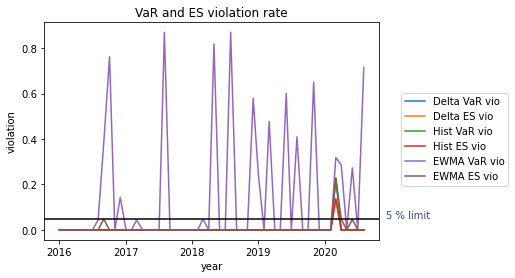

In [84]:
#Accuracy of the prediction
#Ideally should be under the 5% limit line
plt.plot(violation_df)
plt.xlabel('year')
plt.ylabel('violation')
plt.legend(violation_df.columns, bbox_to_anchor=(1.05, 0.7))
#add a 0.05 limit line
plt.axhline(y=0.05, color='black', linestyle='-')
plt.text(x=dt.datetime(2020, 12, 1), y=0.05, s='5 % limit', alpha=1, color='#334f8d')
plt.title('VaR and ES violation rate')
plt.show()

In [85]:
# Normally Distributed?
print('Skewness : ',skew(ptf_naive_BL_4['return_m'].sort_values()))
print('Kurtosis : ',kurtosis(ptf_naive_BL_4['return_m'].sort_values()))

Skewness :  -1.8358319183144944
Kurtosis :  21.540248724229585


In [86]:
# NUMBER OF VIOLATIONS

for i in violation_df.columns:
    x = violation_df[violation_df[i]>0].count()[i]
    #x = violation_df[i].value_counts()
    print(i, ':', x)


Delta VaR vio : 1
Delta ES vio : 1
Hist VaR vio : 1
Hist ES vio : 1
EWMA VaR vio : 19
EWMA ES vio : 4


[]

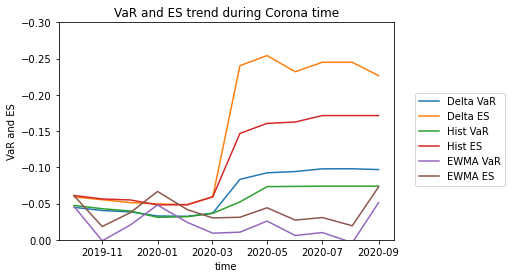

In [87]:
#how did VaR and ES evolve during the recent Corona crisis
corona_var_es = var_es_df.tail(12)
plt.plot(corona_var_es)
plt.title('VaR and ES trend during Corona time')
#plt.axvline(x='2020-03', color='r', linestyle='-')
plt.xlabel('time')
plt.ylabel('VaR and ES')
plt.ylim(0, -0.3)
plt.legend(corona_var_es.columns, bbox_to_anchor=(1.05, 0.7))
plt.plot()

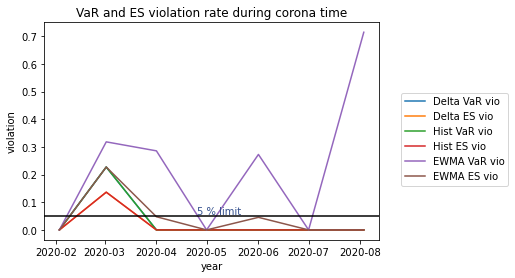

In [88]:
#Accuracy of the prediction during corona time
#Ideally should be under the 5% limit line
corona_vio = violation_df.tail(7)
plt.plot(corona_vio)
plt.title('VaR and ES violation rate during corona time')
plt.xlabel('year')
plt.ylabel('violation')
plt.legend(corona_vio.columns, bbox_to_anchor=(1.05, 0.7))
#add a 0.05 limit line
plt.axhline(y=0.05, color='black', linestyle='-')
plt.text(x=dt.datetime(2020, 4, 25), y=0.056, s='5 % limit', alpha=1, color='#334f8d')
plt.show()

In [89]:
# NUMBER OF VIOLATIONS DURING CORONA CRISIS

for i in corona_vio.columns:
    x = corona_vio[corona_vio[i]>0.00].count()[i]
    #x = violation_df[i].value_counts()
    print(i, ':', x)


Delta VaR vio : 1
Delta ES vio : 1
Hist VaR vio : 1
Hist ES vio : 1
EWMA VaR vio : 4
EWMA ES vio : 3


QUES 4

(c) Using the baseline model from exercise 1 together with the two Markowitz portfolios MRS and MinV, as well as the simple 1/N portfolio, how do the
20-day 95% VaR and ES evolve from January 1st 2016 until September 1st 2020? Which portfolio, besides the “naïve” baseline portfolio and the benchmark
portfolio, provided the lowest VaR and ES at the end of January 31st 2020 before the Corona crisis hit the financial markets? Do the VaR and ES ex-
ante predict reasonably how sensitive the portfolios are to exogeneous shocks like the Corona crisis with large drawdowns from February 20th to March
23rd 2020?

In [90]:
ptf_msr_4 = ptf_msr_1.iloc[368:1796, :]
ptf_min_4 = ptf_min_1.iloc[368:1796, :]
ptf_n_4 = ptf_n_1.iloc[368:1796, :]

In [91]:
var_es_20days_msr = get_var_es(ptf_msr_4, timeframe = 20)
var_es_20days_msr

,Delta VaR,Delta ES,Hist VaR,Hist ES
Date,,,,
2016-01-01,-0.068790,-0.090355,-0.075485,-0.092998
2016-02-01,-0.070794,-0.091169,-0.073200,-0.092725
2016-03-01,-0.070973,-0.092059,-0.075485,-0.093338
2016-04-01,-0.069193,-0.092278,-0.065986,-0.090333
2016-05-02,-0.067498,-0.093745,-0.063030,-0.089233
2016-06-01,-0.064743,-0.092202,-0.062203,-0.087725
2016-07-01,-0.060821,-0.087520,-0.060673,-0.087520
2016-08-01,-0.060302,-0.088320,-0.058822,-0.086098
2016-09-01,-0.057145,-0.079685,-0.057217,-0.079685


In [92]:
var_es_20days_min = get_var_es(ptf_min_4, timeframe = 20)
var_es_20days_min.tail(10)

,Delta VaR,Delta ES,Hist VaR,Hist ES
Date,,,,
2019-12-02,-0.007549,-0.009481,-0.006851,-0.009280
2020-01-01,-0.007464,-0.009588,-0.006467,-0.009168
2020-02-03,-0.006909,-0.009798,-0.006122,-0.008783
2020-03-02,-0.007066,-0.009798,-0.006149,-0.008846
2020-04-01,-0.030987,-0.103490,-0.009123,-0.041014
2020-05-01,-0.031842,-0.103490,-0.011212,-0.043357
2020-06-01,-0.031931,-0.103490,-0.011350,-0.043357
2020-07-01,-0.032020,-0.103490,-0.012307,-0.043581
2020-08-03,-0.031927,-0.103490,-0.012307,-0.043581


In [93]:
var_es_20days_n = get_var_es(ptf_n_4, timeframe = 20)
var_es_20days_n.tail(10)

,Delta VaR,Delta ES,Hist VaR,Hist ES
Date,,,,
2019-12-02,-0.024543,-0.034212,-0.024713,-0.034212
2020-01-01,-0.021480,-0.029614,-0.021211,-0.029614
2020-02-03,-0.021869,-0.032128,-0.021041,-0.030509
2020-03-02,-0.024503,-0.039690,-0.023282,-0.038451
2020-04-01,-0.062342,-0.183572,-0.030370,-0.107524
2020-05-01,-0.067614,-0.160930,-0.042651,-0.117729
2020-06-01,-0.068173,-0.174217,-0.042870,-0.119187
2020-07-01,-0.070119,-0.181663,-0.045965,-0.125099
2020-08-03,-0.069738,-0.181663,-0.045965,-0.125099


In [94]:
#Give higher level columns names
columns_BL = [('Baseline', 'Delta VaR'), ('Baseline', 'Delta ES'), ('Baseline', 'Hist VaR'), ('Baseline', 'Hist ES')]
columns_BL = pd.MultiIndex.from_tuples(columns_BL)
columns_msr = [('MSR', 'Delta VaR'), ('MSR', 'Delta ES'), ('MSR', 'Hist VaR'), ('MSR', 'Hist ES')]
columns_msr = pd.MultiIndex.from_tuples(columns_msr)
columns_min = [('MIN', 'Delta VaR'), ('MIN', 'Delta ES'), ('MIN', 'Hist VaR'), ('MIN', 'Hist ES')]
columns_min = pd.MultiIndex.from_tuples(columns_min)
columns_n = [('1/N', 'Delta VaR'), ('1/N', 'Delta ES'), ('1/N', 'Hist VaR'), ('1/N', 'Hist ES')]
columns_n = pd.MultiIndex.from_tuples(columns_n)

var_es_20days.columns = columns_BL
var_es_20days_msr.columns = columns_msr
var_es_20days_min.columns = columns_min
var_es_20days_n.columns = columns_n

In [95]:
#compare VaR and ES for portfolios with different weighting
all_df = pd.concat([var_es_20days, var_es_20days_msr, var_es_20days_min, var_es_20days_n], axis = 1)
all_df

Baseline                                     MSR            \
           Delta VaR  Delta ES  Hist VaR   Hist ES Delta VaR  Delta ES   
Date                                                                     
2016-01-01 -0.040992 -0.060875 -0.037700 -0.059122 -0.068790 -0.090355   
2016-02-01 -0.045240 -0.061550 -0.047646 -0.063773 -0.070794 -0.091169   
2016-03-01 -0.047445 -0.063003 -0.049234 -0.065271 -0.070973 -0.092059   
2016-04-01 -0.047552 -0.063182 -0.048250 -0.064350 -0.069193 -0.092278   
2016-05-02 -0.047534 -0.064309 -0.047677 -0.064309 -0.067498 -0.093745   
2016-06-01 -0.047852 -0.064309 -0.047646 -0.064309 -0.064743 -0.092202   
2016-07-01 -0.050584 -0.073437 -0.048827 -0.069873 -0.060821 -0.087520   
2016-08-01 -0.050159 -0.071527 -0.049032 -0.069873 -0.060302 -0.088320   
2016-09-01 -0.046117 -0.062239 -0.047646 -0.063379 -0.057145 -0.079685   
2016-10-03 -0.045567 -0.062333 -0.047610 -0.063477 -0.057234 -0.084018   
2016-11-01 -0.045871 -0.061541 -0.047950 -0.063679 -0.058894 -0.083920   
2016-12-01 -0.045571 -0.061541 -0.047946 -0.063679 -0.062315 -0.092792   
2017-01-02 -0.043648 -0.060298 -0.046242 -0.061456 -0.058424 -0.081845   
2017-02-01 -0.038881 -0.056322 -0.038246 -0.056322 -0.056514 -0.081156   
2017-03-01 -0.036546 -0.054162 -0.035205 -0.052753 -0.053804 -0.076496   
2017-04-03 -0.036104 -0.055853 -0.031985 -0.052391 -0.053455 -0.077958   
2017-05-01 -0.035549 -0.055853 -0.031529 -0.052387 -0.052615 -0.080190   
2017-06-01 -0.034829 -0.054895 -0.033192 -0.053339 -0.052105 -0.080190   
2017-07-03 -0.030545 -0.043670 -0.030495 -0.043670 -0.052404 -0.078128   
2017-08-01 -0.030460 -0.043322 -0.030715 -0.044297 -0.051573 -0.078285   
2017-09-01 -0.030956 -0.044632 -0.031318 -0.044632 -0.048961 -0.073191   
2017-10-02 -0.027513 -0.038138 -0.028362 -0.038899 -0.044708 -0.068562   
2017-11-01 -0.025666 -0.035589 -0.026502 -0.036287 -0.041730 -0.063607   
2017-12-01 -0.025285 -0.036032 -0.025348 -0.036032 -0.036770 -0.047333   
2018-01-01 -0.024534 -0.033814 -0.025039 -0.034494 -0.036689 -0.048362   
2018-02-01 -0.024266 -0.034547 -0.024516 -0.034547 -0.037839 -0.053098   
2018-03-01 -0.029780 -0.047324 -0.029185 -0.047324 -0.042557 -0.059336   
2018-04-02 -0.030437 -0.047758 -0.032043 -0.048997 -0.042047 -0.060678   
2018-05-01 -0.031488 -0.047262 -0.035580 -0.050584 -0.042011 -0.059631   
2018-06-01 -0.031023 -0.047454 -0.033340 -0.049833 -0.042870 -0.059631   
2018-07-02 -0.030916 -0.047069 -0.035692 -0.050423 -0.042266 -0.059770   
2018-08-01 -0.031086 -0.046765 -0.034198 -0.050101 -0.042995 -0.060477   
2018-09-03 -0.030451 -0.047203 -0.032678 -0.049618 -0.042950 -0.060477   
2018-10-01 -0.031354 -0.048339 -0.032790 -0.049618 -0.043661 -0.060477   
2018-11-01 -0.036913 -0.054770 -0.038711 -0.057476 -0.048286 -0.062055   
2018-12-03 -0.039078 -0.055383 -0.042959 -0.058634 -0.048415 -0.062127   
2019-01-01 -0.043693 -0.058196 -0.046318 -0.062274 -0.049650 -0.063661   
2019-02-01 -0.044399 -0.060079 -0.046318 -0.062274 -0.047364 -0.065526   
2019-03-01 -0.040509 -0.052981 -0.044095 -0.055423 -0.042933 -0.060088   
2019-04-01 -0.040254 -0.053129 -0.043035 -0.055857 -0.042128 -0.058151   
2019-05-01 -0.039198 -0.051837 -0.041725 -0.055486 -0.042132 -0.059725   
2019-06-03 -0.042060 -0.056210 -0.044095 -0.058236 -0.041846 -0.058357   
2019-07-01 -0.042119 -0.057203 -0.044127 -0.058236 -0.042208 -0.058697   
2019-08-01 -0.042235 -0.057203 -0.044095 -0.058236 -0.041971 -0.056188   
2019-09-02 -0.044686 -0.059099 -0.047543 -0.061112 -0.042731 -0.056188   
2019-10-01 -0.044748 -0.059099 -0.047454 -0.061112 -0.044261 -0.057677   
2019-11-01 -0.040410 -0.055298 -0.042870 -0.056322 -0.040437 -0.054502   
2019-12-02 -0.038505 -0.051286 -0.039681 -0.054994 -0.041609 -0.057914   
2020-01-01 -0.032857 -0.049556 -0.031010 -0.048165 -0.042002 -0.057521   
2020-02-03 -0.032360 -0.048415 -0.031922 -0.048415 -0.042852 -0.059001   
2020-03-02 -0.036748 -0.059345 -0.036542 -0.059345 -0.044574 -0.061049   
2020-04-01 -0.08

In [96]:
columns_ewma = [('Baseline', 'EWMA VaR'), ('Baseline', 'EWMA ES')]
columns_ewma = pd.MultiIndex.from_tuples(columns_ewma)
var_es_20days_ewma.columns = columns_ewma

In [97]:
delta_var_trend = all_df.iloc[ : ,[0, 4, 8, 12]]
delta_es_trend = all_df.iloc[ : ,[1, 5, 9, 13]]
hist_var_trend = all_df.iloc[ : ,[2, 6, 10, 14]]
hist_es_trend = all_df.iloc[ : ,[3, 7, 11, 15]]
trends = [delta_var_trend, delta_es_trend, hist_var_trend, hist_es_trend]

In [98]:
delta_var_trend

,Baseline,MSR,MIN,1/N
,Delta VaR,Delta VaR,Delta VaR,Delta VaR
Date,,,,
2016-01-01,-0.040992,-0.068790,-0.009396,-0.034413
2016-02-01,-0.045240,-0.070794,-0.009727,-0.038366
2016-03-01,-0.047445,-0.070973,-0.009763,-0.040316
2016-04-01,-0.047552,-0.069193,-0.009740,-0.039619
2016-05-02,-0.047534,-0.067498,-0.009839,-0.039945
2016-06-01,-0.047852,-0.064743,-0.009758,-0.039874
2016-07-01,-0.050584,-0.060821,-0.009405,-0.042839
2016-08-01,-0.050159,-0.060302,-0.009646,-0.042387


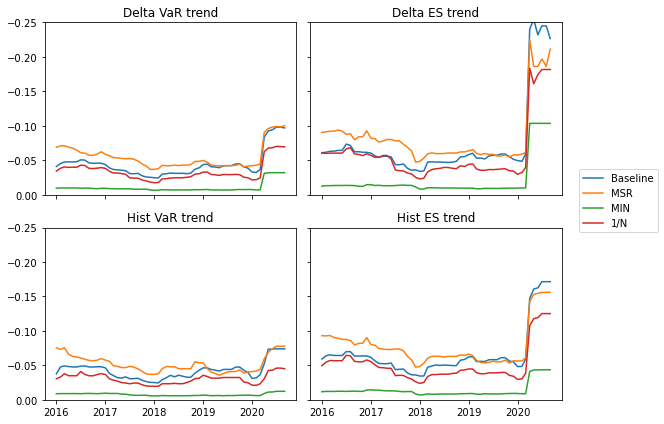

In [99]:
#make a single legend for many subplots with matplotlib?
#delta es trend's baseline look weird, check the largets number
fig, axs = plt.subplots(2, 2, figsize = (8, 6), sharey = True, sharex = True)
axs[0, 0].plot(delta_var_trend)
axs[0, 0].set_title('Delta VaR trend')
plt.ylim(0, -0.25)

axs[0, 1].plot(delta_es_trend)
axs[0, 1].set_title('Delta ES trend')
#plt.ylim(0, -0.1)

axs[1, 0].plot(hist_var_trend)
axs[1, 0].set_title('Hist VaR trend')
plt.ylim(0, -0.25)

axs[1, 1].plot(hist_es_trend)
axs[1, 1].set_title('Hist ES trend')
#plt.ylim(0, -0.1)

line_labels = ['Baseline', 'MSR', 'MIN', '1/N']
fig.legend(labels= line_labels, bbox_to_anchor=(1.15, 0.6), borderaxespad=0.1)
fig.tight_layout()

In [100]:
# VaR and ES for different portfolio's on January 31st 2020 

for i,y in all_df.columns:
    x = all_df.loc['2020-1-31':'2020-3-1'][i,y].min()
    #x = violation_df[i].value_counts()
    print(i,y,x)

Baseline Delta VaR -0.03236
Baseline Delta ES -0.048415
Baseline Hist VaR -0.031922
Baseline Hist ES -0.048415
MSR Delta VaR -0.042852
MSR Delta ES -0.059001
MSR Hist VaR -0.041913
MSR Hist ES -0.05642
MIN Delta VaR -0.006909
MIN Delta ES -0.009798
MIN Hist VaR -0.006122
MIN Hist ES -0.008783
1/N Delta VaR -0.021869
1/N Delta ES -0.032128
1/N Hist VaR -0.021041
1/N Hist ES -0.030509


In [101]:
#arrays_4 = [np.array(['Historical simulation', 'Historical simulation', 'Delta Normal', 'Delta Normal']),np.array(['VaR', 'ES', 'VaR', 'ES'])]
#data = {'classic ETF' : [hist_var_20d, hist_es_20d, delta_var_20d, delta_es_20d], 'MSR': [hist_var_20d_msr, hist_es_20d_msr, delta_var_20d_msr, delta_es_20d_msr], 'MIN': [hist_var_20d_min, hist_es_20d_min, delta_var_20d_min, delta_es_20d_min], '1/n': [hist_var_20d_n, hist_es_20d_n, delta_var_20d_n, delta_es_20d_n]}
#df = pd.DataFrame(data, index = arrays_4)
#df

QUES 4

(d) With the large losses in the recent Corona crisis one might want to make the retirement portfolio more robust against large losses and high in
absolute maximum drawdowns. Therefore the iShares Edge MSCI Min Vol USA ETF (USMV) replace the 70% share of the Russell 2000 ETF in the 60% equity
allocation of the baseline portfolio from exercise 1. All other ETFs for European, emerging market and Japanese equity as well as US bonds are
unchanged. Calculate for this “minimum volatility” portfolio the 20-day 95% VaR and ES as of January 31st 2020, using the two methods from part (a)
and compare it to the VaR and ES of the baseline portfolio. What do you observe? Also calculate the returns, volatility, Sharpe-Ratio and maximum
drawdown of the “minimum volatility” portfolio compared to the baseline portfolio for 2020 and in particular during the Corona crisis. What do you
observe? Are the 20-day 95% VaR and ES good predictors which portfolio would make less losses, in absolute terms, in the case of an exogeneous shock
like the Corona crisis? Finally calculate the Markowitz minimum volatility (MinV) portfolio weights for the “minimum volatility” portfolio as of
January 31st 2020. How did this optimized “minimum volatility” portfolio perform in the Corona crisis regarding its returns, maximum drawdown and
Sharpe-Ratio compared to the simple, non-optimized, “minimum volatility” portfolios and what is this MinV “minimum volatility” portfolio 20-day 95%
VaR and ES using the methods from part (a) as of January 31st 2020? Elaborate what you observe and whether you would recommend as financial advisor
such an optimized or simple “minimum volatility” portfolio to a risk-averse client.


In [102]:
#4d
ptf_col_usmv = np.r_[21, 10:17]
initial_weight = np.array([0.42, 0.06, 0.06, 0.06, 0.1, 0.1, 0.1, 0.1])
columns = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']
ptf_BL_usmv = get_df(ptf_col_usmv, initial_weight, columns, 8, 2656)
ptf_BL_usmv

,iShares Edge MSCI Min Vol USA ETF (USMV) $,iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) €,iShares MSCI Emerging Markets ETF (EEM) $,iShares Core Nikkei 225 ETF (1329.T) ¥,iShares 20+ Year Treasury Bond ETF (TLT) $,iShares Core U.S. Aggregate Bond ETF (AGG) $,SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $,iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $,w1,w2,w3,w4,w5,w6,w7,w8,return_m,portfolio_value
Date,,,,,,,,,,,,,,,,,,
2013-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.420000,0.060000,0.060000,0.060000,0.100000,0.100000,0.100000,0.100000,NaN,NaN
2013-07-18,0.002666,0.006359,-0.011791,0.016598,-0.012493,-0.001862,0.006673,-0.002612,0.420800,0.060336,0.059247,0.060950,0.098676,0.099738,0.100591,0.099663,0.000760,401304.758197
2013-07-19,0.002364,-0.000156,-0.002792,-0.027020,0.015813,0.002611,-0.000491,0.005499,0.421166,0.060236,0.058994,0.059214,0.100087,0.099849,0.100392,0.100062,0.001491,401903.206892
2013-07-22,0.000295,0.005087,0.009928,0.010816,0.001465,0.001303,0.002211,0.002257,0.420289,0.060399,0.059438,0.059713,0.099995,0.099742,0.100375,0.100049,0.002378,402859.081928
2013-07-23,-0.001179,-0.000330,0.010839,0.037160,-0.004206,-0.000558,-0.002941,-0.001559,0.419198,0.060293,0.059997,0.061844,0.099433,0.099545,0.099937,0.099752,0.001419,403430.915105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,-0.013993,-0.003626,-0.016056,0.005949,0.005083,0.000085,-0.003707,0.000740,0.414050,0.060290,0.059340,0.060499,0.102568,0.101288,0.100749,0.101215,-0.006458,682661.047095
2020-09-11,0.002996,0.003586,0.009653,0.007535,0.002132,0.001184,0.002385,0.000739,0.413991,0.060317,0.059725,0.060764,0.102465,0.101091,0.100673,0.100973,0.003134,684800.626562
2020-09-14,0.013991,0.003470,0.016162,0.007469,-0.000061,0.000084,-0.001333,0.002512,0.416640,0.060073,0.060236,0.060759,0.101692,0.100343,0.099787,0.100469,0.007514,689946.382923


In [103]:
#ptf_BL_usmv_4d = ptf_BL_usmv.iloc[1395:1647, :]
ptf_BL_usmv_4d = ptf_BL_usmv.iloc[368:1796, :]
ptf_BL_usmv_4d

,iShares Edge MSCI Min Vol USA ETF (USMV) $,iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) €,iShares MSCI Emerging Markets ETF (EEM) $,iShares Core Nikkei 225 ETF (1329.T) ¥,iShares 20+ Year Treasury Bond ETF (TLT) $,iShares Core U.S. Aggregate Bond ETF (AGG) $,SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $,iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $,w1,w2,w3,w4,w5,w6,w7,w8,return_m,portfolio_value
Date,,,,,,,,,,,,,,,,,,
2014-12-31,-0.011236,0.000705,0.000764,0.009828,0.001910,0.000273,-0.004384,0.000670,0.420000,0.060000,0.060000,0.060000,0.100000,0.100000,0.100000,0.100000,-0.004260,459799.089374
2015-01-02,0.000741,-0.005100,-0.013235,-0.003437,0.011118,0.002815,0.001813,0.003517,0.419920,0.059638,0.059151,0.059738,0.101018,0.100188,0.100088,0.100258,0.000931,460227.067232
2015-01-05,-0.009380,-0.032901,-0.017797,-0.009676,0.015709,0.002173,-0.006980,0.004089,0.418499,0.058025,0.058450,0.059518,0.103226,0.101014,0.099991,0.101278,-0.006034,457450.041577
2015-01-06,-0.002741,-0.007781,-0.004202,-0.020929,0.018017,0.002530,-0.004686,0.004072,0.417782,0.057633,0.058264,0.058333,0.105194,0.101374,0.099625,0.101795,-0.001031,456978.312393
2015-01-07,0.012744,-0.000547,0.021625,0.007498,-0.001975,-0.000180,0.005493,0.001325,0.419979,0.057176,0.059084,0.058336,0.104210,0.100606,0.099432,0.101176,0.007418,460368.349186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,0.002636,0.013132,0.002654,-0.004704,-0.003826,-0.000169,-0.000189,0.000369,0.423916,0.062204,0.062191,0.062076,0.095037,0.098142,0.099176,0.097256,0.001429,691127.311052
2020-08-27,0.004640,-0.005690,-0.008381,0.001826,-0.017009,-0.003464,-0.001323,-0.007961,0.426590,0.061953,0.061772,0.062293,0.093576,0.097965,0.099210,0.096642,-0.001658,689981.229747
2020-08-28,0.004618,-0.006826,0.013123,-0.021059,-0.000744,0.001357,0.000662,0.003046,0.427931,0.061440,0.062491,0.060891,0.093369,0.097954,0.099130,0.096794,0.001468,690994.306570


In [104]:
#calculate VaR and ES
var_es_20days_usmv = get_var_es(ptf_BL_usmv_4d, timeframe = 20)
var_es_20days_usmv

,Delta VaR,Delta ES,Hist VaR,Hist ES
Date,,,,
2016-01-01,-0.035352,-0.056599,-0.031546,-0.051170
2016-02-01,-0.038237,-0.054444,-0.036976,-0.054444
2016-03-01,-0.039323,-0.057315,-0.037530,-0.054444
2016-04-01,-0.037476,-0.055687,-0.035786,-0.052731
2016-05-02,-0.037396,-0.055687,-0.035786,-0.052731
2016-06-01,-0.036859,-0.055687,-0.035746,-0.052731
2016-07-01,-0.037432,-0.057928,-0.036430,-0.056295
2016-08-01,-0.037324,-0.057928,-0.036475,-0.056295
2016-09-01,-0.032499,-0.049068,-0.030920,-0.046376


In [105]:
columns_usmv = [('Min Vol', 'Delta VaR'), ('Min Vol', 'Delta ES'), ('Min Vol', 'Hist VaR'), ('Min Vol', 'Hist ES')]
columns_usmv = pd.MultiIndex.from_tuples(columns_usmv)
var_es_20days_usmv.columns = columns_usmv

In [106]:
#Calculate the 20-day 95% VaR and ES as of January 31st 2020 and compare it to the VaR and ES of the baseline portfolio
print(var_es_20days.iloc[49, :])
print(var_es_20days_usmv.iloc[49, :])
print()
print('We can observe that the the VaR and ES for the Minimum volatility portfolio is much lower, which is mainly due to less volatility in this portfolio')

Baseline  Delta VaR   -0.032360
          Delta ES    -0.048415
          Hist VaR    -0.031922
          Hist ES     -0.048415
Name: 2020-02-03 00:00:00, dtype: float64
Min Vol  Delta VaR   -0.021256
         Delta ES    -0.031864
         Hist VaR    -0.021551
         Hist ES     -0.031864
Name: 2020-02-03 00:00:00, dtype: float64

We can observe that the the VaR and ES for the Minimum volatility portfolio is much lower, which is mainly due to less volatility in this portfolio


In [107]:
#EWMA
ptf_BL_usmv_ewma = get_df(ptf_col_usmv, initial_weight, columns, 8, 2018)
ptf_BL_usmv_ewma

,iShares Edge MSCI Min Vol USA ETF (USMV) $,iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) €,iShares MSCI Emerging Markets ETF (EEM) $,iShares Core Nikkei 225 ETF (1329.T) ¥,iShares 20+ Year Treasury Bond ETF (TLT) $,iShares Core U.S. Aggregate Bond ETF (AGG) $,SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $,iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $,w1,w2,w3,w4,w5,w6,w7,w8,return_m,portfolio_value
Date,,,,,,,,,,,,,,,,,,
2010-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.420000,0.060000,0.060000,0.060000,0.100000,0.100000,0.100000,0.100000,NaN,NaN
2011-01-03,NaN,0.011790,0.009656,0.004401,-0.007544,-0.001134,0.004030,0.003873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,NaN,0.001337,0.004574,0.008777,0.001178,0.000284,0.003010,0.001286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,NaN,-0.003383,-0.002483,-0.004486,-0.022027,-0.004827,0.004751,-0.007340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,NaN,-0.006732,-0.010581,-0.001544,0.004373,0.000190,0.000498,0.001479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,-0.013993,-0.003626,-0.016056,0.005949,0.005083,0.000085,-0.003707,0.000740,0.420000,0.060000,0.060000,0.060000,0.100000,0.100000,0.100000,0.100000,-0.006502,818062.735673
2020-09-11,0.002996,0.003586,0.009653,0.007535,0.002132,0.001184,0.002385,0.000739,0.420000,0.060000,0.060000,0.060000,0.100000,0.100000,0.100000,0.100000,0.003144,820634.606067
2020-09-14,0.013991,0.003470,0.016162,0.007469,-0.000061,0.000084,-0.001333,0.002512,0.420000,0.060000,0.060000,0.060000,0.100000,0.100000,0.100000,0.100000,0.007594,826866.389785


In [108]:
#calculate VaR and ES for 5 years window
var_es_20days_usmv_ewma = get_var_es_ewma(ptf_BL_usmv_ewma, timeframe = 20)
var_es_20days_usmv_ewma.head()

,EWMA VaR,EWMA ES
Date,,
2016-01-01,-0.029231,-0.058168
2016-02-01,-0.012950,-0.035414
2016-03-01,-0.000160,-0.017803
2016-04-01,-0.002960,-0.020645
2016-05-02,-0.018184,-0.041632


In [109]:
columns_usmv_ewma = [('Min Vol', 'EWMA VaR'), ('Min Vol', 'EWMA ES')]
columns_usmv_ewma = pd.MultiIndex.from_tuples(columns_usmv_ewma)
var_es_20days_usmv_ewma.columns = columns_usmv_ewma

In [110]:
#EWMA - Calculate the 20-day 95% VaR and ES as of January 31st 2020 and compare it to the VaR and ES of the baseline portfolio
print(var_es_20days_ewma.iloc[49, :])
print(var_es_20days_usmv_ewma.iloc[49, :])

Baseline  EWMA VaR   -0.023974
          EWMA ES    -0.041574
Name: 2020-02-03 00:00:00, dtype: float64
Min Vol  EWMA VaR   -0.025448
         EWMA ES    -0.038676
Name: 2020-02-03 00:00:00, dtype: float64


In [111]:
#calculate the returns, volatility, Sharpe-Ratio and maximum drawdown of the “minimum volatility” portfolio compared to the baseline portfolio for 2020 and in particular during the Corona crisis. What do you observe
def year_fig(*ptf, s, e):
    d = []
    for t, i in zip(ptf, range(len(ptf))):
        mean_pi = float(t.iloc[s:e,-2].mean()) *252
        std_i = t.iloc[s:e,-2].std() * math.sqrt(252)
        MDD_i = min(((t.iloc[s:e,-1].dropna()[::-1].cummin())-(t.iloc[s:e,-1].dropna().cummax()))/(t.iloc[s:e,-1].dropna().cummax()))
        SR_i = (float(t.iloc[s:e,-2].mean()) *252 - - np.mean(time_series_all.iloc[:, 6] / 100))/(t.iloc[s:e,-2].std() * math.sqrt(252))
        #data = [mean_pi, std_i, MDD_i, SR_i]
        d.append({'Annual return' : mean_pi,
                  'volatility' : std_i,
                  'Max DD' : MDD_i,
                  'Sharpe Ratio' : SR_i})
    return pd.DataFrame(d)

In [112]:
#2020 figure
year_fig(ptf_BL_usmv, ptf_naive_BL, s = 1627, e = 1805)

,Annual return,volatility,Max DD,Sharpe Ratio
0,0.053882,0.210060,-0.232282,0.315282
1,0.019642,0.251459,-0.282304,0.127210


In [113]:
#corona figure
#MDD correct?
year_fig(ptf_BL_usmv, ptf_naive_BL, s = 1660, e = 1682)

,Annual return,volatility,Max DD,Sharpe Ratio
0,-2.887437,0.416276,-0.228730,-6.906696
1,-3.523649,0.462039,-0.282304,-7.599575


In [114]:
#calculate the MinV portfolio weights for the “minimum volatility” portfolio as of January 31st 2020. 
VCV_ret_4 = ptf_BL_usmv.iloc[1: 1647, :8]      #extract data till 2020-01-30
VCV_4 = pypfopt.risk_models.sample_cov(VCV_ret_4, returns_data=True, frequency=252)
VCV_in_4 = np.linalg.inv(VCV_4)
mu_4 = pypfopt.expected_returns.mean_historical_return(VCV_ret_4, returns_data= True, frequency=252)

In [115]:
#MIN with pyportfolioOpt as of 31st Jan
ef_min_4 = EfficientFrontier(mu_4, VCV_4, weight_bounds=(-2,2))
Min_ptf_4 = ef_min_4.min_volatility()
clean_MIN_4 = ef_min_4.clean_weights()
Wmin_4 = [0.00841, 0.00824, -0.0337, 0.01398, -0.22975, 1.3302, 0.07057, -0.16795]

ptf_min_4d = get_df(ptf_col_usmv, Wmin_4, columns, 8, 2656)
ptf_min_4d_new = pd.concat([ptf_min_4d, year_Q], axis = 1)
ptf_min_4d_new['Quarter'] = ptf_min_4d_new.iloc[:,-1]
ptf_min_4d_new = ptf_min_4d_new.drop(ptf_min_4d_new.columns[-2], axis = 1)

In [116]:
year_fig(ptf_BL_usmv, ptf_min_4d, s = 1660, e = 1682).round(5)

,Annual return,volatility,Max DD,Sharpe Ratio
0,-2.88744,0.41628,-0.22873,-6.90670
1,-0.63444,0.24404,-0.08290,-2.54921


In [117]:
year_fig(ptf_BL_usmv, ptf_min_4d, s = 1660, e = 1682)

,Annual return,volatility,Max DD,Sharpe Ratio
0,-2.887437,0.416276,-0.228730,-6.906696
1,-0.634444,0.244036,-0.082903,-2.549209


In [118]:
#How did this optimized “minimum volatility” portfolio perform in the Corona crisis compared to the non-optimized “minimum volatility” portfolios  
year_fig(ptf_BL_usmv, ptf_min_4d, s = 1660, e = 1682)
print('The performance for MIN weighting compared to the simple weightings: Less volatility, better SR, return, and lower MDD ')

The performance for MIN weighting compared to the simple weightings: Less volatility, better SR, return, and lower MDD 


In [119]:
#get df
ptf_min_4d_2 = ptf_min_4d.iloc[368:1796, :]

#calculate VaR and ES
var_es_20days_usmv_min = get_var_es(ptf_min_4d_2, timeframe = 20)
var_es_20days_usmv_min.head()

,Delta VaR,Delta ES,Hist VaR,Hist ES
Date,,,,
2016-01-01,-0.008560,-0.011753,-0.007665,-0.009785
2016-02-01,-0.008788,-0.010916,-0.007934,-0.010094
2016-03-01,-0.008828,-0.010916,-0.008184,-0.010111
2016-04-01,-0.008725,-0.011010,-0.007920,-0.009937
2016-05-02,-0.008649,-0.011073,-0.007907,-0.010179


In [120]:
columns_usmv_min = [('Min Vol-min', 'Delta VaR'), ('Min Vol-min', 'Delta ES'), ('Min Vol-min', 'Hist VaR'), ('Min Vol-min', 'Hist ES')]
columns_usmv_min = pd.MultiIndex.from_tuples(columns_usmv_min)
var_es_20days_usmv_min.columns = columns_usmv_min
print(var_es_20days_usmv_min.iloc[49, :])

Min Vol-min  Delta VaR   -0.006096
             Delta ES    -0.008197
             Hist VaR    -0.005599
             Hist ES     -0.007822
Name: 2020-02-03 00:00:00, dtype: float64
